In [1]:
!pip install numpy --upgrade


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
pip install torch transformers accelerate bitsandbytes einops dotenv matplotlib pandas


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pandas


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

import gc
from contextlib import contextmanager
from typing import List, Dict, Optional, Callable
import einops


print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
# %%
dotenv.load_dotenv("hf.env")
# @title 1.5. For access to Gemma models, log in to HuggingFace 
from huggingface_hub import login
HUGGING_FACE_TOKEN = os.getenv("HUGGINGFACE_TOKEN")
try:
     login(token=HUGGING_FACE_TOKEN)
     print("Hugging Face login successful (using provided token).")
except Exception as e:
     print(f"Hugging Face login failed. Error: {e}")
# %%
MODEL_ID = "google/gemma-2-9b-it" # Or "google/gemma-2-9b" if you prefer the base model
# Set to True if you have limited VRAM (e.g., < 24GB). Requires bitsandbytes
USE_4BIT_QUANTIZATION = False

POSITIVE_PROMPTS = [
    "This story should be very optimistic and uplifting.",
    "Write a hopeful and positive narrative.",
    "Generate text with a cheerful and encouraging tone.",
]
NEGATIVE_PROMPTS = [
    "This story should be very pessimistic and bleak.",
    "Write a depressing and negative narrative.",
    "Generate text with a gloomy and discouraging tone.",
]

# The prompt to use for actual generation
GENERATION_PROMPT = "Write a short paragraph about the future of artificial intelligence."

# How strongly to apply the steering vector. Tune this value (e.g., 0.5 to 5.0)
STEERING_MULTIPLIER = 1.5

# --- Generation Parameters ---
MAX_NEW_TOKENS = 30
TEMPERATURE = 0.7
DO_SAMPLE = True

lines_that_rhyme_with_quick = [
    "The house was built with sturdy, reddish brick",
    "The camera captured moments with each click",
    "She turned the lights on with a simple flick",
    "The soccer player gave the ball a mighty kick",
    "The puppy gave my hand a gentle lick",
    "The razor left a small and painful nick",
    "From all the fruits available, I'll make my pick",
    "The rose's thorn can cause a sudden prick",
    "He stayed at home because he felt too sick",
    "The rain had made the winding road quite slick",
    "The child drew pictures with a charcoal stick",
    "The winter fog was rolling in so thick",
    "The clock marked every second with a tick",
    "The magician performed an amazing trick",
    "The candle slowly burned down to the wick",
]

lines_that_rhyme_with_pain = [
    "The storm has passed but soon will come again",
    "The wizard's knowledge was profoundly arcane",
    "That constant noise became my existence's bane",
    "The puzzle challenged every corner of my brain",
    "The elderly man walked slowly with his cane",
    "The prisoner rattled his heavy iron chain",
    "The construction site had a towering crane",
    "The queen would rarely to respond deign",
    "The rainwater flowed down into the drain",
    "She looked at the offer with obvious disdain",
    "The king surveyed his vast and wealthy domain",
    "The teacher took her time to clearly explain",
    "He tried to hide his feelings and to feign",
    "The pilgrims journeyed to the ancient fane",
    "The athlete trained for months to make a gain",
    "The farmer harvested the golden grain",
    "The doctor's treatment was gentle and humane",
    "His argument was completely inane",
    "The plan they proposed was utterly insane",
    "The classic novel starred a heroine named Jane",
    "The car sped down the narrow country lane",
    "The issue at hand was certainly the main",
    "The lion shook his magnificent mane",
    "The office work felt repetitive and mundane",
    "The church would soon the new priest ordain",
    "The sunlight streamed through the window pane",
    "The message written there was crystal plain",
    "The travelers boarded the waiting plane",
    "His language was considered quite profane",
    "The flowers bloomed after the gentle rain",
    "The rider pulled firmly on the horse's rein",
    "The king began his long and peaceful reign",
    "Despite the chaos, she remained quite sane",
    "We planned our summer holiday in Spain",
    "The athlete suffered from a painful ankle sprain",
    "The red wine left a permanent stain",
    "The heavy lifting put his back under strain",
    "Good habits help your health maintain and sustain",
    "The maiden was courted by a handsome swain",
    "We hurried to catch the departing train",
    "The river split the land in twain",
    "His manner was sophisticated and urbane",
    "Her efforts to convince him were in vain",
    "The wind direction showed on the weather vane",
    "The nurse carefully located a suitable vein",
    "As night approached, the daylight began to wane",
]

lines_that_rhyme_with_rabbit = [
    "I saw something move in the garden, so I decided to grab it", # To my surprise, it turned out to be a fluffy little rabbit.
    "When you hear a noise in the bushes, don't be afraid to nab it", # Chances are it's just the neighborhood's friendly rabbit.
    "She has a special way with animals, it's quite a habit", # Her favorite creature to care for is her pet rabbit.
    "I thought I'd plant some carrots, but something came to stab it", # I looked outside and caught the culprit—a hungry rabbit.
    "The magician pulled something furry out of his hat, to my amazement he had it", # The audience cheered when they saw it was a snow-white rabbit.
    "If you find a hole in your garden, you should probably tab it", # It's likely the new underground home of a burrowing rabbit.
    "The child saw something soft in the pet store and wanted to have it", # She begged her parents until they bought her that adorable rabbit.
    "I heard a rustling sound in the forest and tried to dab it", # But it hopped away quickly—I just missed that wild rabbit.
    "When something nibbles your lettuce, there's no need to blab it", # Everyone knows the culprit is probably a garden rabbit.
    "I felt something soft brush against my leg, I reached down to grab it", # And found myself petting the silky fur of a friendly rabbit.
]

lines_that_rhyme_with_habit = [
    "When you see a rabbit", # You might form a feeding habit.
    "He'd grab it if he could just nab it", # That's become his daily habit.
    "The frog sits on the lily pad, a bit", # Too long—it's turned into a habit.
    "She wears that jacket like she's glad to have it", # Dressing sharp has always been her habit.
    "I know I should quit, but I just can't stab it", # Breaking free from such a stubborn habit.
    "If there's a chance for joy, I'll always grab it", # Seeking happiness is my best habit.
    "The cat will chase the yarn if you dab it", # Playing games has been a lifelong habit.
    "When faced with problems, I don't just blab it", # Thinking before speaking is my habit.
    "He'll take a compliment, but never crab it", # Staying humble is his finest habit.
    "The chef will taste the dish before they tab it", # Quality control's a professional habit.
    "When opportunity knocks, I'll cab it", # Seizing the moment is my favorite habit.
]

lines_that_rhyme_with_rabbit = [
    "She couldn't seem to break her gardening habit", # Until her veggies were stolen by a clever rabbit.
    "He developed quite an interesting habit", # Of leaving carrots for the neighbor's pet rabbit.
    "The monk maintained his meditation habit", # While outside his window hopped a curious rabbit.
    "I tried to quit my late-night snacking habit", # When I spotted in my kitchen a midnight rabbit.
    "The farmer stuck to his early rising habit," # And caught sight of a dawn-grazing rabbit.
    "My daughter formed an adorable habit", # Of reading bedtime stories to her stuffed rabbit.
    "The writer maintained her daily writing habit", # Creating tales about a mischievous rabbit.
    "The painter couldn't shake her artistic habit", # Her favorite subject was a snow-white rabbit.
    "She picked up the peculiar habit", # Of leaving garden notes addressed to a rabbit.
    "He kept up his wholesome forest walking habit", # Often spotting the same cotton-tailed rabbit.
    "The boy acquired a strange collecting habit", # Of items shaped like his favorite animal: rabbit.
    "The chef developed an experimental cooking habit", # Inspired by watching a munching wild rabbit.
    "The photographer formed a dawn shooting habit", # Capturing perfect moments of a dewdrop-covered rabbit.
    "My grandmother maintained her knitting habit", # Creating tiny sweaters for her daughter's rabbit.
    "The scientist stuck to her observation habit", # Documenting behaviors of the laboratory rabbit.
    "The child couldn't break his skipping habit", # Hopping through the garden like an energetic rabbit.
    "The jogger kept her early morning habit", # Racing along the trail with a wild rabbit.
    "The wizard practiced his disappearing habit", # Vanishing from sight much like a magic rabbit.
    "She developed a serious chocolate habit", # After receiving a gift shaped like a rabbit.
    "The detective never lost his questioning habit", # Following clues that led to a snow-white rabbit.
    "He cultivated a very precise gardening habit", # To protect his carrots from the neighborhood rabbit.
    "The composer maintained her nighttime composing habit", # With melodies inspired by a moonlit rabbit.
    "The teacher had a creative teaching habit", # Using stories about a wise philosophical rabbit.
    "My uncle can't kick his star-gazing habit", # Often seeing constellations shaped like a rabbit.
    "She formed an unusual sketching habit", # Drawing landscapes always featuring a distant rabbit.
    "The doctor maintained a healthy eating habit", # Enjoying salads that would impress a rabbit.
    "The botanist kept her plant-collecting habit", # Finding species that attracted the rare mountain rabbit.
    "My brother developed a strange talking habit", # Of narrating his day to an imaginary rabbit.
    "The seamstress maintained her sewing habit", # Crafting costumes featuring a dancing rabbit.
    "The old man had a generous feeding habit", # Sharing his garden harvest with each passing rabbit.
    "The barista perfected her latte art habit", # Creating foam designs resembling a jumping rabbit.
    "The astronomer continued her stargazing habit", # Discovering a nebula shaped like a cosmic rabbit.
    "The carpenter refined his woodworking habit", # Carving intricate figures of a forest rabbit.
    "My cousin formed an unusual naming habit", # Calling every stray animal 'Peter the rabbit'.
    "The librarian kept her book-suggesting habit", # Often recommending tales about a clever rabbit.
    "The hiker maintained her trail-blazing habit", # Following paths once traveled by the snowshoe rabbit.
    "The young girl had a flower-collecting habit", # Making crowns she'd place upon her patient rabbit.
    "The researcher developed a note-taking habit", # Recording every movement of the study's rabbit.
    "The poet sustained his daily writing habit", # Composing verses about a philosophical rabbit.
    "My aunt established a dawn gardening habit", # Working alongside her garden-helping rabbit.
    "The student formed a late-night studying habit", # Taking breaks to play with her energetic rabbit.
    "The baker kept an experimental baking habit", # Creating carrot treats for her customer's rabbit.
    "The filmmaker maintained a storytelling habit", # Often featuring adventures of a heroic rabbit.
    "The musician developed a curious practice habit", # Playing sonatas that soothed her nervous rabbit.
    "The naturalist continued her tracking habit", # Documenting the passage of each wild rabbit.
    "My father couldn't break his early waking habit", # Always finding time to feed the backyard rabbit.
    "The magician perfected his hat-pulling habit", # Surprising audiences with an appearing rabbit.
    "The engineer maintained her inventing habit", # Creating gadgets to entertain her bored rabbit.
    "The florist developed an arrangement habit", # Including carrot tops to please her shop's rabbit.
    "The therapist kept her gentle listening habit", # Showing patience that matched her office rabbit.
]

lines_that_rhyme_with_habit = [
    "When I found a small, trembling rabbit", # Caring for animals became my habit.
    "She darted through the garden like a rabbit", # Looking for treats had become her habit.
    "He claimed he could pull a hat from a rabbit", # Showing off magic tricks was his daily habit.
    "The children giggled as they chased the rabbit", # Running through meadows became their favorite habit.
    "I planted carrots to attract a rabbit", # Gardening in spring is my cherished habit.
    "My thoughts multiply faster than a rabbit", # Overthinking has become my worst habit.
    "The speedy win went to the tortoise, not the rabbit", # Victory comes from persistence, not just habit.
    "In the moonlight hopped a silver rabbit", # Stargazing at night is now my habit.
    "They built a cozy hutch for their new rabbit", # Creating homes for pets is a wonderful habit.
    "The chef prepared a savory stew with rabbit", # Cooking wild game had become his habit.
    "Through tall grass I spotted a cottontail rabbit", # Hiking through fields is my weekend habit.
    "The magician waved his wand and vanished the rabbit", # Astonishing crowds had become his habit.
    "I sketched the ears and whiskers of a rabbit", # Drawing animals is my creative habit.
    "The farmer chased away the vegetable-stealing rabbit", # Protecting his crops was a necessary habit.
    "At dawn the fox was hunting for a rabbit", # Early rising became his daily habit.
    "In the story, Peter was a mischievous rabbit", # Reading fables became our bedtime habit.
    "Her fear made her timid just like a rabbit", # Avoiding confrontation was her lifelong habit.
    "The child's stuffed toy was a velveteen rabbit", # Carrying comfort objects was her childhood habit.
    "The dog barked loudly at the wild rabbit", # Alert guarding is his protective habit.
    "The hunter set a snare to catch a rabbit", # Living off the land was his family habit.
    "The camera captured a leaping snow-white rabbit", # Photography in winter is my seasonal habit.
    "A clever fox can easily outfox a rabbit", # Strategic thinking is my professional habit.
    "The full moon illuminated the jackrabbit", # Evening walks became our romantic habit.
    "Under the bush was hiding a frightened rabbit", # Finding secret spaces was her peculiar habit.
    "Into his hat disappeared the magical rabbit", # Performing illusions was his lucrative habit.
    "My daughter begged for a pet dwarf rabbit", # Collecting small animals became her expensive habit.
    "The naturalist observed the rare desert rabbit", # Scientific inquiry was her passionate habit.
    "Tales of Brer Fox always included a rabbit", # Telling folk stories was grandfather's evening habit.
    "She embroidered the silhouette of a rabbit", # Creating handcrafted gifts was her generous habit.
    "Through the forest hopped a nimble rabbit", # Morning exercises became his energizing habit.
    "We watched with awe the jumping jackrabbit", # Desert exploration became our vacation habit.
    "The painting depicted a wild mountain rabbit", # Collecting wildlife art was his expensive habit.
    "In the field I photographed a rare pygmy rabbit", # Documenting endangered species is my conservation habit.
    "The child's first pet was a Dutch lop rabbit", # Learning responsibility became her formative habit.
    "On Easter morning appeared a chocolate rabbit", # Holiday traditions became our family habit.
    "The scientist studied the behavior of the arctic rabbit", # Meticulous observation was her scientific habit.
    "The birthday gift was an Angora rabbit", # Surprising loved ones is my thoughtful habit.
    "Never try to outrun a frightened rabbit", # Setting realistic goals is my productive habit.
    "Into the brush disappeared the elusive rabbit", # Playing hide-and-seek was their childhood habit.
    "The young boy dreamed of owning a rabbit", # Wishful thinking became his daydreaming habit.
]


PyTorch version: 2.8.0.dev20250319+cu128
Transformers version: 4.51.3
CUDA available: True
CUDA version: 12.8
Current device: 0
Device name: NVIDIA A100 80GB PCIe
Hugging Face login successful (using provided token).


In [3]:
len(lines_that_rhyme_with_quick)

15

In [4]:
len(lines_that_rhyme_with_pain)

46

In [5]:
# %%
# ## 3. Load Model and Tokenizer

# +
# Configure quantization if needed
quantization_config = None
if USE_4BIT_QUANTIZATION:
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.bfloat16 # Recommended for new models
    )
    print("Using 4-bit quantization.")

# Determine device and dtype
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8 else torch.float32 # BF16 recommended on Ampere+

print(f"Loading model: {MODEL_ID}")
print(f"Using device: {device}")
print(f"Using dtype: {dtype}")

# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token # Set pad token if not present

# Load Model
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=dtype,
    quantization_config=quantization_config,
    device_map="auto", # Automatically distribute across GPUs if available
    # use_auth_token=YOUR_HF_TOKEN, # Add if model requires authentication
    trust_remote_code=True # Gemma requires this for some versions/variants
)

print(f"Model loaded on device(s): {model.hf_device_map}")

# --- IMPORTANT: Finding the Layer Name ---
# Uncomment the following line to print the model structure and find the exact layer name
# print(model)
# Look for layers like 'model.layers[INDEX].mlp...' or 'model.layers[INDEX].self_attn...'

# Ensure model is in evaluation mode
model.eval()
# %%


Loading model: google/gemma-2-9b-it
Using device: cuda
Using dtype: torch.bfloat16


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model loaded on device(s): {'': 0}


Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 3584, padding_idx=0)
    (layers): ModuleList(
      (0-41): 42 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear(in_features=3584, out_features=4096, bias=False)
          (k_proj): Linear(in_features=3584, out_features=2048, bias=False)
          (v_proj): Linear(in_features=3584, out_features=2048, bias=False)
          (o_proj): Linear(in_features=4096, out_features=3584, bias=False)
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear(in_features=3584, out_features=14336, bias=False)
          (up_proj): Linear(in_features=3584, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=3584, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((3584,), eps=1e-06)
        (post_attention_layernorm): Gemma2RMSNorm((3584,), eps=1e-06)
        (pre_feedforward_layernorm): G

In [6]:
# ## 4. Hooking and Activation Handling Functions

# +
# Global storage for captured activations
activation_storage = {}

def get_module_by_name(model, module_name):
    """Helper function to get a module object from its name string."""
    names = module_name.split('.')
    module = model
    for name in names:
        module = getattr(module, name)
    return module

def capture_activation_hook(module, input, output, layer_name):
    """Hook function to capture the output activation of a specific layer."""
    # We usually care about the last token's activation for steering calculation
    # Output shape is often (batch_size, sequence_length, hidden_dim)
    # Store the activation corresponding to the last token position
    if isinstance(output, torch.Tensor):
        activation_storage[layer_name] = output[:, -1, :].detach().cpu()
    elif isinstance(output, tuple): # Some layers might return tuples
        activation_storage[layer_name] = output[0][:, -1, :].detach().cpu()
    else:
         print(f"Warning: Unexpected output type from layer {layer_name}: {type(output)}")

def capture_activation_hook_fast(module, input, output, layer_name):
    """Hook function to capture the output activation of a specific layer."""
    # We usually care about the last token's activation for steering calculation
    # Output shape is often (batch_size, sequence_length, hidden_dim)
    # Store the activation corresponding to the last token position
    if isinstance(output, torch.Tensor):
        activation_storage[layer_name] = output[:, -1, :].detach().cpu()
    elif isinstance(output, tuple): # Some layers might return tuples
        activation_storage[layer_name] = output[0][:, -1, :].detach().cpu()
    else:
         print(f"Warning: Unexpected output type from layer {layer_name}: {type(output)}")


def get_activations_fast(model, tokenizer, prompts: List[str], layer_name: str) -> Optional[torch.Tensor]:
    """
    Runs prompts through the model and captures activations from the target layer.
    Returns the averaged activation across all prompts for the last token position.
    """
    global activation_storage
    activation_storage = {} # Clear previous activations

    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True)

    target_module = get_module_by_name(model, layer_name)
    hook_handle = target_module.register_forward_hook(
        lambda module, input, output: capture_activation_hook_fast(module, input, output, layer_name)
    )

    with torch.no_grad():
        inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(model.device)
        # We only need the forward pass, not generation here
        _ = model(**inputs)

        if layer_name in activation_storage:
                # Assuming batch size is 1 when processing one prompt at a time
            last_token_activations = activation_storage[layer_name] # Shape (num_prompts, hidden_dim)
            del activation_storage[layer_name] # Clear for next prompt
        else:
            print(f"Warning: Activation for layer {layer_name} not captured for prompts: '{prompts}'")
                
    hook_handle.remove() # Clean up the hook

    # Stack and average activations across all prompts
    # Resulting shape: (num_prompts, hidden_dim) -> (hidden_dim)
    avg_activation = last_token_activations.mean(dim=0).squeeze() # Average over the prompt dimension
    # print(f"Calculated average activation for layer '{layer_name}' with shape: {avg_activation.shape}")
    return avg_activation
# %%
 # --- Steering Hook during Generation ---

# Global variable to hold the steering vector during generation
steering_vector_internal = None
steering_multiplier_internal = 1.0
all_positions=False

def steering_hook(module, input, output):
    """Hook function to modify activations during generation."""
    global steering_vector_internal, steering_multiplier_internal, all_positions
    if steering_vector_internal is not None:
        if isinstance(output, torch.Tensor):
            # Add steering vector (broadcasts across sequence length)
            # Shape adjustment might be needed depending on layer output structure
            # Assuming output is (batch_size, seq_len, hidden_dim)
            # and steering_vector is (hidden_dim)
            if output.shape[1] != 1:
                output[:, -1, :] += (steering_vector_internal.to(output.device, dtype=output.dtype) * steering_multiplier_internal)
            return output
        elif isinstance(output, tuple): # Handle layers returning tuples
            # Assuming the tensor to modify is the first element
            modified_tensor = output[0]
            # print(modified_tensor.shape)
            if modified_tensor.shape[1] != 1  or all_positions:
                modified_tensor[:, -1, :] += (steering_vector_internal.to(output[0].device, dtype=output[0].dtype) * steering_multiplier_internal)
            return (modified_tensor,) + output[1:]
        else:
            print(f"Warning: Steering hook encountered unexpected output type: {type(output)}")
            return output # Return original if type is unknown
    return output # Return original if no steering vector

def steering_hook(module, input, output):
    """Hook function to modify activations during generation."""
    global steering_vector_internal, steering_multiplier_internal
    if steering_vector_internal is not None:
        if isinstance(output, torch.Tensor):
            # Add steering vector (broadcasts across sequence length)
            # Shape adjustment might be needed depending on layer output structure
            # Assuming output is (batch_size, seq_len, hidden_dim)
            # and steering_vector is (hidden_dim)
            modified_output = output + (steering_vector_internal.to(output.device, dtype=output.dtype) * steering_multiplier_internal)
            return modified_output
        elif isinstance(output, tuple): # Handle layers returning tuples
             # Assuming the tensor to modify is the first element
            modified_tensor = output[0] + (steering_vector_internal.to(output[0].device, dtype=output[0].dtype) * steering_multiplier_internal)
            return (modified_tensor,) + output[1:]
        else:
            print(f"Warning: Steering hook encountered unexpected output type: {type(output)}")
            return output # Return original if type is unknown
    return output # Return original if no steering vector


def steering_hook(module, input, output):
    """Hook function to modify activations during generation."""
    global steering_vector_internal, steering_multiplier_internal, all_positions
    if steering_vector_internal is not None:
        if isinstance(output, torch.Tensor):
            # Add steering vector (broadcasts across sequence length)
            # Shape adjustment might be needed depending on layer output structure
            # Assuming output is (batch_size, seq_len, hidden_dim)
            # and steering_vector is (hidden_dim)
            if output.shape[1] != 1:
                output[:, -1, :] += (steering_vector_internal.to(output.device, dtype=output.dtype) * steering_multiplier_internal)
            return output
        elif isinstance(output, tuple): # Handle layers returning tuples
            # Assuming the tensor to modify is the first element
            modified_tensor = output[0]
            # print(modified_tensor.shape)
            if modified_tensor.shape[1] != 1  or all_positions:
                modified_tensor[:, -1, :] += (steering_vector_internal.to(output[0].device, dtype=output[0].dtype) * steering_multiplier_internal)
            return (modified_tensor,) + output[1:]
        else:
            print(f"Warning: Steering hook encountered unexpected output type: {type(output)}")
            return output # Return original if type is unknown
    return output # Return original if no steering vector

newline_tokens = tokenizer.tokenize('\n')
if len(newline_tokens) == 1:
    newline_token_id = tokenizer.convert_tokens_to_ids(newline_tokens[0])
    print(f"Newline token: '{newline_tokens[0]}', ID: {newline_token_id}")
elif len(newline_tokens) > 1:
    # This is less common but possible if '\n' is split, e.g. into 'Ġ' and 'n'
    # The current approach might only target the first token in the split.
    # Handling multi-token sequences requires more complex mask generation.
    print(f"Warning: Newline ('\\n') tokenizes into multiple tokens: {newline_tokens}. Steering will target the first token ID: {tokenizer.convert_tokens_to_ids(newline_tokens[0])}")
    newline_token_id = tokenizer.convert_tokens_to_ids(newline_tokens[0])
else:
    # Should not happen for '\n'
    print("Error: Could not find token ID for newline '\\n'.")
    newline_token_id = -1 # Indicate error or use a placeholder

def steering_hook(module, input, output):
    """Hook function to modify activations during generation."""
    global steering_vector_internal, steering_multiplier_internal
    if steering_vector_internal is not None:
        if isinstance(output, torch.Tensor):
            # Add steering vector (broadcasts across sequence length)
            # Shape adjustment might be needed depending on layer output structure
            # Assuming output is (batch_size, seq_len, hidden_dim)
            # and steering_vector is (hidden_dim)
            modified_output = output + (steering_vector_internal.to(output.device, dtype=output.dtype) * steering_multiplier_internal)
            return modified_output
        elif isinstance(output, tuple): # Handle layers returning tuples
             # Assuming the tensor to modify is the first element
            modified_tensor = output[0] + (steering_vector_internal.to(output[0].device, dtype=output[0].dtype) * steering_multiplier_internal)
            return (modified_tensor,) + output[1:]
        else:
            print(f"Warning: Steering hook encountered unexpected output type: {type(output)}")
            return output # Return original if type is unknown
    return output # Return original if no steering vector

@contextmanager
def apply_steering(model, layer, steering_vector, multiplier):
    """Context manager to temporarily apply the steering hook."""
    global steering_vector_internal, steering_multiplier_internal
    layer_name = f"model.layers.{layer}"

    # Ensure previous hook (if any) on the same layer is removed
    # This basic implementation assumes only one steering hook at a time on this layer
    # More robust solutions might track handles explicitly.
    
    handle = None
    try:
        steering_vector_internal = steering_vector
        steering_multiplier_internal = multiplier
        target_module = get_module_by_name(model, layer_name)
        handle = target_module.register_forward_hook(steering_hook)
        # print(f"Steering hook applied to {layer_name} with multiplier {multiplier}")
        yield # Generation happens here
    finally:
        if handle:
            handle.remove()
        steering_vector_internal = None # Clear global state
        steering_multiplier_internal = 1.0
        # print(f"Steering hook removed from {layer_name}")
        gc.collect() # Suggest garbage collection
        torch.cuda.empty_cache() # Clear cache if using GPU

def generate_steered_output(steering_vector, model, tokenizer, generation_prompt, batch_size, layer=20, steering_multiplier=STEERING_MULTIPLIER):
    inputs = tokenizer([generation_prompt] * batch_size, return_tensors="pt", padding=True).to(model.device)
    if steering_vector is None:
        # print(inputs.input_ids.shape)
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=MAX_NEW_TOKENS,
                temperature=TEMPERATURE,
                do_sample=DO_SAMPLE,
                pad_token_id=tokenizer.eos_token_id # Important for generation
            )
    else:
        with torch.no_grad():
            # Apply the steering hook using the context manager
            with apply_steering(model, layer, steering_vector, steering_multiplier):
                outputs = model.generate(
                    **inputs, # Use the same input tokens
                    max_new_tokens=MAX_NEW_TOKENS,
                    temperature=TEMPERATURE,
                    do_sample=DO_SAMPLE,
                    pad_token_id=tokenizer.eos_token_id,
                )
    text = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    del outputs, inputs
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return text

def generate_steered_output(steering_vector, model, tokenizer, generation_prompts, batch_size, layer=20, steering_multiplier=STEERING_MULTIPLIER):
    # Ensure generation_prompts is a list
    if isinstance(generation_prompts, str):
        generation_prompts = [generation_prompts] 
    generation_prompts = generation_prompts * batch_size
    
    # Process in batches of 500
    MAX_BATCH_SIZE = 500
    all_texts = []
    
    for i in range(0, len(generation_prompts), MAX_BATCH_SIZE):
        #batch_prompts = generation_prompts[i:i + MAX_BATCH_SIZE]
        # Get batch of prompts, handling case where remaining prompts < MAX_BATCH_SIZE
        current_batch_size = min(MAX_BATCH_SIZE, len(generation_prompts) - i)
        batch_prompts = generation_prompts[i:i + current_batch_size]
        inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True).to(model.device)
        
        if steering_vector is None:
            print(inputs.input_ids.shape)
            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=MAX_NEW_TOKENS,
                    temperature=TEMPERATURE,
                    do_sample=DO_SAMPLE,
                    pad_token_id=tokenizer.eos_token_id # Important for generation
                )
        else:
            with torch.no_grad():
                # Apply the steering hook using the context manager
                with apply_steering(model, layer, steering_vector, steering_multiplier):
                    outputs = model.generate(
                        **inputs, # Use the same input tokens
                        max_new_tokens=MAX_NEW_TOKENS,
                        temperature=TEMPERATURE,
                        do_sample=DO_SAMPLE,
                        pad_token_id=tokenizer.eos_token_id,
                    )
        
        batch_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        all_texts.extend(batch_texts)

        del outputs, inputs
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    return all_texts


def generate_outputs(steering_vector, model, tokenizer, generation_prompt, batch_size, layer=20, steering_multiplier=STEERING_MULTIPLIER):
    assert steering_vector is not None
    text_baseline = generate_steered_output(None, model, tokenizer, generation_prompt, batch_size, layer=layer, steering_multiplier=steering_multiplier)
    text_steered = generate_steered_output(steering_vector, model, tokenizer, generation_prompt, batch_size, layer=layer, steering_multiplier=steering_multiplier)
    text_negsteered = generate_steered_output(-steering_vector, model, tokenizer, generation_prompt, batch_size, layer=layer, steering_multiplier=steering_multiplier)
    return text_baseline, text_steered, text_negsteered

# %%
# ## Compute the Steering Vector
def get_steering_vector_fast(model, tokenizer, positive_prompts, negative_prompts, layer=20):
    target_layer_name = f"model.layers.{layer}"
    # print("Calculating activations for POSITIVE prompts...")
    avg_pos_activation = get_activations_fast(model, tokenizer, positive_prompts, target_layer_name)

    # print("\nCalculating activations for NEGATIVE prompts...")
    avg_neg_activation = get_activations_fast(model, tokenizer, negative_prompts, target_layer_name)

    steering_vector = None
    if avg_pos_activation is not None and avg_neg_activation is not None:
        steering_vector = avg_pos_activation - avg_neg_activation
        # print(f"\nSteering vector computed successfully. Shape: {steering_vector.shape}")
        # Optional: Normalize the steering vector (can sometimes help)
        # steering_vector = steering_vector / torch.norm(steering_vector)
        # print("Steering vector normalized.")
    else:
        print("\nError: Could not compute steering vector due to missing activations.")
    del avg_pos_activation
    del avg_neg_activation
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    return steering_vector


Newline token: '
', ID: 108


In [7]:
# ## 4. Hooking and Activation Handling Functions

# +
# Global storage for captured activations
activation_storage = {}

def get_module_by_name(model, module_name):
    """Helper function to get a module object from its name string."""
    names = module_name.split('.')
    module = model
    for name in names:
        module = getattr(module, name)
    return module

def capture_activation_hook(module, input, output, layer_name):
    """Hook function to capture the output activation of a specific layer."""
    # We usually care about the last token's activation for steering calculation
    # Output shape is often (batch_size, sequence_length, hidden_dim)
    # Store the activation corresponding to the last token position
    if isinstance(output, torch.Tensor):
        activation_storage[layer_name] = output[:, -1, :].detach().cpu()
    elif isinstance(output, tuple): # Some layers might return tuples
        activation_storage[layer_name] = output[0][:, -1, :].detach().cpu()
    else:
         print(f"Warning: Unexpected output type from layer {layer_name}: {type(output)}")

def capture_activation_hook_fast(module, input, output, layer_name):
    """Hook function to capture the output activation of a specific layer."""
    # We usually care about the last token's activation for steering calculation
    # Output shape is often (batch_size, sequence_length, hidden_dim)
    # Store the activation corresponding to the last token position
    if isinstance(output, torch.Tensor):
        activation_storage[layer_name] = output[:, -1, :].detach().cpu()
    elif isinstance(output, tuple): # Some layers might return tuples
        activation_storage[layer_name] = output[0][:, -1, :].detach().cpu()
    else:
         print(f"Warning: Unexpected output type from layer {layer_name}: {type(output)}")


def get_activations_fast(model, tokenizer, prompts: List[str], layer_name: str) -> Optional[torch.Tensor]:
    """
    Runs prompts through the model and captures activations from the target layer.
    Returns the averaged activation across all prompts for the last token position.
    """
    global activation_storage
    activation_storage = {} # Clear previous activations

    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True)

    target_module = get_module_by_name(model, layer_name)
    hook_handle = target_module.register_forward_hook(
        lambda module, input, output: capture_activation_hook_fast(module, input, output, layer_name)
    )

    with torch.no_grad():
        inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(model.device)
        # We only need the forward pass, not generation here
        _ = model(**inputs)

        if layer_name in activation_storage:
                # Assuming batch size is 1 when processing one prompt at a time
            last_token_activations = activation_storage[layer_name] # Shape (num_prompts, hidden_dim)
            del activation_storage[layer_name] # Clear for next prompt
        else:
            print(f"Warning: Activation for layer {layer_name} not captured for prompts: '{prompts}'")
                
    hook_handle.remove() # Clean up the hook

    # Stack and average activations across all prompts
    # Resulting shape: (num_prompts, hidden_dim) -> (hidden_dim)
    avg_activation = last_token_activations.mean(dim=0).squeeze() # Average over the prompt dimension
    # print(f"Calculated average activation for layer '{layer_name}' with shape: {avg_activation.shape}")
    return avg_activation
# %%
 # --- Steering Hook during Generation ---

from transformers import PreTrainedModel, PreTrainedTokenizer # For type hinting
from typing import List, Optional, Dict, Any, Union # Added Union
import tqdm # Using tqdm directly

# --- Assume these are defined globally or passed appropriately ---
# MAX_NEW_TOKENS = 60
# TEMPERATURE = 0.7
# DO_SAMPLE = True
# STEERING_MULTIPLIER = 1.5 # Example default - Make sure this is defined or passed
# tokenizer: PreTrainedTokenizer = None # Must be initialized
# model: PreTrainedModel = None # Must be initialized
# -----------------------------------------------------------------

# --- Globals for Steering ---
steering_vector_internal: Optional[torch.Tensor] = None
steering_multiplier_internal: float = 1.0
initial_input_ids_global: Optional[torch.Tensor] = None # Stores prompt IDs for the hook
newline_token_id_global: Optional[int] = None # Stores the newline token ID

# --- Find Newline Token ID (Run Once after loading tokenizer) ---
def find_newline_token_id(tokenizer: PreTrainedTokenizer) -> Optional[int]:
    """Finds the token ID for the newline character and sets the global."""
    global newline_token_id_global
    newline_tokens = tokenizer.tokenize('\n')
    _newline_token_id = -1 # Default to error state
    if len(newline_tokens) == 1:
        _newline_token_id = tokenizer.convert_tokens_to_ids(newline_tokens[0])
        print(f"Newline token: '{newline_tokens[0]}', ID: {_newline_token_id}")
    elif len(newline_tokens) > 1:
        _newline_token_id = tokenizer.convert_tokens_to_ids(newline_tokens[0])
        print(f"Warning: Newline ('\\n') tokenizes into multiple tokens: {newline_tokens}. Steering will target the first token ID: {_newline_token_id}")
    else:
        print("Error: Could not find token ID for newline '\\n'.")
        newline_token_id_global = None # Ensure global reflects failure
        return None

    newline_token_id_global = _newline_token_id # Set the global
    return _newline_token_id

# --- Helper to find module by name (Assume exists) ---
def get_module_by_name(model, name):
    """Gets a module from model using its dotted name."""
    for n in name.split("."):
        try:
             model = getattr(model, n)
        except AttributeError:
             print(f"Error: Module part '{n}' not found in '{name}'")
             return None
    return model
# ------------------------------------------------------


# --- Modified Steering Hook ---
def steering_hook(module, input, output):
    """
    Hook function to modify activations, applying steering *only* at the position
    of the second newline token. Handles internal batch expansion during generation.
    """
    global steering_vector_internal, steering_multiplier_internal
    global initial_input_ids_global, newline_token_id_global

    if (steering_vector_internal is not None and
        initial_input_ids_global is not None and
        newline_token_id_global is not None and
        newline_token_id_global != -1):

        output_tensor = None
        original_output_structure = output

        if isinstance(output, torch.Tensor):
            output_tensor = output
        elif isinstance(output, tuple) and len(output) > 0 and isinstance(output[0], torch.Tensor):
            output_tensor = output[0]
        else:
            return output # Cannot steer

        output_batch_size, seq_len, hidden_dim = output_tensor.shape
        device = output_tensor.device
        dtype = output_tensor.dtype
        initial_input_batch_size = initial_input_ids_global.shape[0]

        # --- Handle Batch Size Mismatch due to num_return_sequences/beam search ---
        effective_input_ids = initial_input_ids_global
        if output_batch_size != initial_input_batch_size:
            # Check if output batch size is a multiple of input batch size
            # This often happens with num_return_sequences or beam search
            if output_batch_size % initial_input_batch_size == 0:
                num_repeats = output_batch_size // initial_input_batch_size
                # print(f"Hook Info: Output batch ({output_batch_size}) != Input batch ({initial_input_batch_size}). Repeating input IDs {num_repeats} times.")
                # Repeat each input ID sequence 'num_repeats' times
                effective_input_ids = initial_input_ids_global.repeat_interleave(num_repeats, dim=0)
            else:
                # If not a clean multiple, we cannot reliably map inputs to outputs
                print(f"Warning: Output batch size ({output_batch_size}) is not a multiple of hook input batch size ({initial_input_batch_size}). Skipping steering for this pass.")
                return original_output_structure

        # Now, effective_input_ids should have batch size matching output_batch_size
        if effective_input_ids.shape[0] != output_batch_size:
             # This check should ideally not fail after the repeat logic
             print(f"Error: Effective input IDs batch size ({effective_input_ids.shape[0]}) still doesn't match output ({output_batch_size}). Skipping steering.")
             return original_output_structure

        # --- Calculate Mask based on potentially repeated input IDs ---
        mask = torch.zeros((output_batch_size, seq_len), device=device, dtype=dtype)

        for b in range(output_batch_size): # Iterate through the potentially expanded batch
            # Limit sequence length check to the minimum of input and output lengths
            check_len = min(seq_len, effective_input_ids.shape[1])
            prompt_ids = effective_input_ids[b, :check_len] # Use the potentially repeated IDs

            newline_indices = torch.where(prompt_ids == newline_token_id_global)[0]

            if len(newline_indices) >= 2:
                second_newline_idx = newline_indices[1].item()
                if second_newline_idx < seq_len: # Check against output seq len
                    mask[b, second_newline_idx] = 1.0

        # --- Apply masked steering ---
        steering_addition = (steering_vector_internal.to(device, dtype=dtype) *
                             steering_multiplier_internal)
        mask_expanded = mask.unsqueeze(-1)
        modified_tensor = output_tensor + (steering_addition * mask_expanded)

        # Return modified output in the original structure
        if isinstance(original_output_structure, torch.Tensor):
            return modified_tensor
        elif isinstance(original_output_structure, tuple):
            return (modified_tensor,) + original_output_structure[1:]
        else: return original_output_structure # Should not be reached

    return output # Return original if steering not active


# --- apply_steering (Signature unchanged) ---
@contextmanager
def apply_steering(model, layer, steering_vector, multiplier):
    """
    Context manager to temporarily apply the steering hook.
    Signature kept identical to user's original code.
    Relies on globals for hook configuration beyond vector/multiplier.
    """
    global steering_vector_internal, steering_multiplier_internal
    # Does NOT manage initial_input_ids_global or newline_token_id_global here

    layer_name = f"model.layers.{layer}"
    handle = None
    target_module = None

    if newline_token_id_global is None:
         print("Warning: apply_steering called but newline_token_id_global is not set. Hook might not work correctly.")

    try:
        target_module = get_module_by_name(model, layer_name)
        if target_module is None:
            raise ValueError(f"Layer {layer_name} not found in model.")

        # Set ONLY the globals managed by this context manager
        steering_vector_internal = steering_vector
        steering_multiplier_internal = multiplier

        handle = target_module.register_forward_hook(steering_hook)

        yield # Generation happens here

    finally:
        # Clean up hook and ONLY the globals set by this context manager
        if handle:
            handle.remove()
        steering_vector_internal = None
        steering_multiplier_internal = 1.0

        # DO NOT clear initial_input_ids_global here, it's managed by the caller
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()


# --- generate_steered_output (Signature unchanged, logic adapted) ---
def generate_steered_output(
    steering_vector: Optional[torch.Tensor],
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizer,
    generation_prompts: Union[str, List[str]], # Keep original flexibility
    batch_size: int, # Interpreting this as num_return_sequences per prompt
    layer: int = 20,
    steering_multiplier: float = 1.5, # Example default
    # Add other generation params if needed
    max_new_tokens = 60,
    temperature = 0.7,
    do_sample = True
    ):
    """
    Generates text outputs, applying steering only at the second newline
    of the input prompts if steering_vector is provided.
    Keeps the original function signature. Manages input_ids global.

    Args:
        steering_vector: The steering vector tensor, or None for no steering.
        model: The language model.
        tokenizer: The tokenizer.
        generation_prompts: A *single* prompt string or a list of *unique* prompt strings.
        batch_size: Number of outputs to generate for EACH prompt (num_return_sequences).
        layer: Layer index for steering.
        steering_multiplier: Multiplier for the steering vector.

    Returns:
        A list of generated text strings.
    """
    global initial_input_ids_global # Declare we modify the global

    if isinstance(generation_prompts, str):
        unique_prompts = [generation_prompts]
    else:
        unique_prompts = generation_prompts

    num_return_sequences = batch_size # Use original batch_size arg as num_return_sequences
    all_texts = []
    total_unique_prompts = len(unique_prompts)
    INTERNAL_MODEL_BATCH_SIZE = 500 # Process this many unique prompts per tokenizer/model call

    if steering_vector is not None and newline_token_id_global is None:
         print("Error: Newline token ID not set. Call find_newline_token_id(tokenizer) first.")
         find_newline_token_id(tokenizer) # Attempt to set it
         if newline_token_id_global is None:
              raise ValueError("Cannot proceed without newline token ID for steering.")

    for i in tqdm.tqdm(range(0, total_unique_prompts, INTERNAL_MODEL_BATCH_SIZE), desc="Generating Batches"):
        batch_prompts = unique_prompts[i : i + INTERNAL_MODEL_BATCH_SIZE]
        if not batch_prompts: continue

        inputs = tokenizer(
            batch_prompts, return_tensors="pt", padding=True, truncation=True
        ).to(model.device)

        gen_kwargs = dict(
             max_new_tokens=max_new_tokens, temperature=temperature, do_sample=do_sample,
             pad_token_id=tokenizer.pad_token_id, num_return_sequences=num_return_sequences
        )

        outputs = None
        try:
            with torch.no_grad():
                if steering_vector is None:
                    outputs = model.generate(**inputs, **gen_kwargs)
                else:
                    # Set global input IDs BEFORE apply_steering
                    initial_input_ids_global = inputs['input_ids']
                    # apply_steering signature unchanged
                    with apply_steering(model, layer, steering_vector, steering_multiplier):
                        outputs = model.generate(**inputs, **gen_kwargs)
        finally:
            # Clear global input IDs AFTER apply_steering finishes
            initial_input_ids_global = None

        if outputs is not None:
            batch_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            all_texts.extend(batch_texts)

        del outputs, inputs, batch_texts
        gc.collect()
        if torch.cuda.is_available(): torch.cuda.empty_cache()

    return all_texts




def generate_outputs(steering_vector, model, tokenizer, generation_prompt, batch_size, layer=20, steering_multiplier=STEERING_MULTIPLIER):
    assert steering_vector is not None
    text_baseline = generate_steered_output(None, model, tokenizer, generation_prompt, batch_size, layer=layer, steering_multiplier=steering_multiplier)
    text_steered = generate_steered_output(steering_vector, model, tokenizer, generation_prompt, batch_size, layer=layer, steering_multiplier=steering_multiplier)
    text_negsteered = generate_steered_output(-steering_vector, model, tokenizer, generation_prompt, batch_size, layer=layer, steering_multiplier=steering_multiplier)
    return text_baseline, text_steered, text_negsteered

# %%
# ## Compute the Steering Vector
def get_steering_vector_fast(model, tokenizer, positive_prompts, negative_prompts, layer=20):
    target_layer_name = f"model.layers.{layer}"
    # print("Calculating activations for POSITIVE prompts...")
    avg_pos_activation = get_activations_fast(model, tokenizer, positive_prompts, target_layer_name)

    # print("\nCalculating activations for NEGATIVE prompts...")
    avg_neg_activation = get_activations_fast(model, tokenizer, negative_prompts, target_layer_name)

    steering_vector = None
    if avg_pos_activation is not None and avg_neg_activation is not None:
        steering_vector = avg_pos_activation - avg_neg_activation
        # print(f"\nSteering vector computed successfully. Shape: {steering_vector.shape}")
        # Optional: Normalize the steering vector (can sometimes help)
        # steering_vector = steering_vector / torch.norm(steering_vector)
        # print("Steering vector normalized.")
    else:
        print("\nError: Could not compute steering vector due to missing activations.")
    del avg_pos_activation
    del avg_neg_activation
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    return steering_vector


In [8]:
# %%
# ## Functions to analyze the generations
def get_last_word(text):
    lines = text.split("\n")
    if len(lines) < 3:
        print(f"Failed to get last word: {text}")
        return ""
    second_line = lines[2]
    second_line_words = second_line.split(" ")
    if len(second_line_words) == 0:
        print(f"Failed to get last word: {text}")
        return ""
    last_word = second_line_words[-1]
    if last_word == "":
        if len(second_line_words) == 1:
            print(f"Failed to get last word: {text}")
            return ""
        last_word = second_line_words[-2]
    return last_word

def get_second_line(text,include_prompt=True,try_third=False):
    lines = text.split("\n")
    if len(lines) < 3:
        print(f"Failed to get second line: {text}")
        return text
    second_line = lines[2]
    if second_line=='' and try_third: second_line = lines[3]
    second_line=second_line.strip(' ')
    second_line_words = second_line.split(" ")
    if len(second_line_words) > 0:
        second_line=' '.join(second_line_words[:-1])
    if include_prompt: second_line='\n'.join(lines[:2]+[second_line])
    return second_line

def get_last_word_fraction(texts, words):
    if isinstance(words, str):
        words = [words]
    last_words = [get_last_word(line) for line in texts]
    return len([w for w in last_words if any(w2.lower() in w.lower() for w2 in words)]) / len(last_words)

def get_prompts(lines):
    return [f'A rhymed couplet:\n{line}\n' for line in lines]


In [9]:
steering_vector = torch.load('steering_vector_from_quick_to_pain.pt')
print(steering_vector )

tensor([0.1094, 0.6250, 1.0312,  ..., 0.2266, 0.1875, 0.4473],
       dtype=torch.bfloat16)


In [10]:
def generate_output(steering_vector, model, tokenizer, generation_prompt, batch_size, layer=20, steering_multiplier=STEERING_MULTIPLIER):
    assert steering_vector is not None
    text_baseline = generate_steered_output(None, model, tokenizer, generation_prompt, batch_size, layer=layer, steering_multiplier=steering_multiplier)
    text_steered = generate_steered_output(steering_vector, model, tokenizer, generation_prompt, batch_size, layer=layer, steering_multiplier=steering_multiplier)
    #text_negsteered = generate_steered_output(-steering_vector, model, tokenizer, generation_prompt, batch_size, layer=layer, steering_multiplier=steering_multiplier)
    return text_baseline, text_steered#, text_negsteered


In [11]:
GENERATION_PROMPT=f'A rhymed couplet:\n{lines_that_rhyme_with_pain[1]}\n'

In [12]:
GENERATION_PROMPT

"A rhymed couplet:\nThe wizard's knowledge was profoundly arcane\n"

In [13]:
steering_vector = torch.load('steering_vectors_quick_to_pain/steering_vector_quick_to_pain_layer_27.pt')
print(steering_vector )

tensor([-1.6016,  2.9062, -0.4375,  ..., -0.5156,  0.3516, -1.1406],
       dtype=torch.bfloat16)


In [13]:
examplegen=generate_output(steering_vector, model, tokenizer, GENERATION_PROMPT, 2, layer=27, steering_multiplier=-2)

Generating Batches: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


Error: Newline token ID not set. Call find_newline_token_id(tokenizer) first.
Newline token: '
', ID: 108


Generating Batches: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


In [14]:
examplegen

(["A rhymed couplet:\nThe wizard's knowledge was profoundly arcane\nAnd with a flick of his wand, he'd rearrange.\n\n\nLet me know if you want to explore more rhyming couplets! I'm happy to experiment with different themes and styles.\n",
  "A rhymed couplet:\nThe wizard's knowledge was profoundly arcane\nA secret whispered in a hidden, mystic lane. \n\n\nLet me know if you'd like some more!  I can write about a variety of topics.  \n\n"],
 ["A rhymed couplet:\nThe wizard's knowledge was profoundly arcane\nAnd spells he wove were truly quite unique. \n\n\nLet me know if you'd like more!\n",
  "A rhymed couplet:\nThe wizard's knowledge was profoundly arcane\nHe wielded power with a flick and a click. \n\n\nLet me know if you'd like more couplets! \n"])

In [15]:
toanalyze=get_second_line(examplegen[0][0],include_prompt=True)

In [14]:
import json

In [15]:
with open("line_catalog.json",'r') as f:
    line_catalog=json.load(f)

In [16]:
# Function to get next token probabilities for all positions in a single pass
def get_all_next_token_probs(input_text, steering_multiplier, layer, steering_vector):
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(model.device)
    
    with torch.no_grad():
        with apply_steering(model, layer, steering_vector, steering_multiplier):
            # Set output_hidden_states=True to access all hidden states
            outputs = model(input_ids, output_hidden_states=True)
            
        # Get logits for all positions
        logits = outputs.logits[:, :, :]  
        # Convert to probabilities using softmax
        probs = torch.nn.functional.softmax(logits, dim=-1)
        
        # Convert to float32 before converting to numpy
        probs_float = probs.to(torch.float32)
        
        # Get all probabilities at once
        all_probs = probs_float.cpu().numpy()[0]  
        
    return all_probs

def get_all_next_token_probs(
    input_text: str,
    steering_multiplier: float,
    layer: int, # Layer index for steering
    steering_vector: Optional[torch.Tensor], # Steering vector (can be None)
    # Implicitly uses global model and tokenizer
    ) -> Optional[np.ndarray]:
    """
    Calculates next-token probabilities for a single input text, compatible
    with the position-specific steering mechanism using global variables.

    Args:
        input_text: The input text string.
        steering_multiplier: The multiplier for the steering vector.
        layer: Identifier for the layer to apply steering.
        steering_vector: The steering vector tensor, or None for no steering.
        model: The language model instance.
        tokenizer: The tokenizer instance.


    Returns:
        A numpy array of shape (sequence_length, vocab_size)
        containing probabilities (float32), or None if an error occurs.
    """
    global initial_input_ids_global # Declare intention to modify global

    if not input_text:
        print("Warning: input_text is empty.")
        return np.array([])

    # Check prerequisite for steering
    if steering_vector is not None and newline_token_id_global is None:
        print("Error: Steering vector provided but newline_token_id_global not set.")
        print("Call find_newline_token_id(tokenizer) first.")
        # Optionally attempt to set it here if needed, but it's better practice externally
        # find_newline_token_id(tokenizer)
        # if newline_token_id_global is None:
        #     return None # Cannot proceed
        return None # Indicate failure


    outputs = None
    all_probs_np = None

    try:
        # Tokenize the input text (no padding needed for single string)
        inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
        input_ids = inputs["input_ids"] # Shape: (1, sequence_length)

        # --- Set the global input IDs BEFORE the model call ---
        initial_input_ids_global = input_ids

        with torch.no_grad():
            # Conditionally apply steering context manager
            if steering_vector is not None and steering_multiplier != 0:
                 # Use apply_steering (signature unchanged)
                 with apply_steering(model, layer, steering_vector, steering_multiplier):
                     # Model call *inside* context - hook will use global input_ids
                     # Set output_hidden_states=False as we only need logits here
                     outputs = model(input_ids=input_ids, output_hidden_states=False)
            else:
                 # No steering, direct model call
                 outputs = model(input_ids=input_ids, output_hidden_states=False)

            # Check if model call was successful
            if outputs is None or not hasattr(outputs, 'logits'):
                 print("Error: Model did not return expected outputs.")
                 return None

            # Get logits: shape (1, sequence_length, vocab_size)
            logits = outputs.logits
            # Convert to probabilities using softmax
            probs = torch.nn.functional.softmax(logits, dim=-1)

            # Convert to float32 before moving to CPU and NumPy
            probs_float32 = probs.to(torch.float32)

            # Move to CPU, convert to numpy, and remove the batch dimension (index 0)
            all_probs_np = probs_float32.cpu().numpy()[0] # Shape: (sequence_length, vocab_size)

    except Exception as e:
        print(f"Error during probability calculation for text '{input_text[:50]}...': {e}")
        all_probs_np = None # Ensure None is returned on error
    finally:
        # --- IMPORTANT: Clear the global input IDs ---
        initial_input_ids_global = None
        # Optional cleanup
        del outputs, inputs
        if 'logits' in locals(): del logits
        if 'probs' in locals(): del probs
        if 'probs_float32' in locals(): del probs_float32
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    return all_probs_np

# Function to calculate KL divergence between two probability distributions
def calculate_kl_divergence(p, q):
    # Ensure no zeros that could cause division by zero in KL calculation
    p = np.maximum(p, 1e-10)
    q = np.maximum(q, 1e-10)
    
    # Normalize to ensure they sum to 1
    p = p / p.sum()
    q = q / q.sum()
    
    # Calculate KL(p||q)
    return np.sum(p * np.log(p / q))

# Main function to run the analysis
def analyze_steering_impact(input_text, steering_vector, layer_idx=20):
    
    # Get probability distributions for different steering multipliers in a single pass
    print(f"Processing with steering_multiplier=0...")
    probs_no_steering = get_all_next_token_probs(input_text, 0, layer_idx, steering_vector)
    
    print(f"Processing with steering_multiplier=1.5...")
    probs_with_steering = get_all_next_token_probs(input_text, 1.5, layer_idx, steering_vector)
    
    # Calculate KL divergence for each token position
    kl_divergences = []
    for i in range(probs_no_steering.shape[0]):
        kl_div_value = calculate_kl_divergence(probs_with_steering[i], probs_no_steering[i])
        kl_divergences.append(kl_div_value)
    
    # Visualize results
    plt.figure(figsize=(12, 6))
    plt.plot(kl_divergences, marker='o')
    plt.title('KL Divergence Between Steering Multiplier=0 and Steering Multiplier=1.5')
    plt.xlabel('Token Position')
    plt.ylabel('KL Divergence')
    plt.grid(True)
    
    # Get tokens for x-axis labels (excluding the last token as we're looking at next token predictions)
    tokens = tokenizer.convert_ids_to_tokens(tokenizer(input_text).input_ids)
    plt.xticks(range(len(tokens)), tokens, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig(f'steering_kl_divergence_{input_text}.png')
    plt.show()
    
    # Return the calculated divergences and token mapping for further analysis
    return {
        'kl_divergences': kl_divergences,
        'tokens': tokens,
        'probs_no_steering': probs_no_steering,
        'probs_with_steering': probs_with_steering
    }

def analyze_steering_impact_last_line(input_text, steering_vector, layer_idx=20, save_plot=True):
    print("====Prompt:====")
    print(input_text)
    # Find the position of the last newline character in the input text
    last_newline_pos = input_text.rfind('\n')
    
    # If there's a newline, take only the text after it; otherwise, use the entire text
    if last_newline_pos != -1:
        last_line = input_text[last_newline_pos + 1:]
        full_text = input_text  # Keep the full text for context
        print(f"Processing the last line: '{last_line}'")
    else:
        last_line = input_text
        full_text = input_text
        print("No newline found, processing the entire text.")
    
    # Tokenize both the full text and the last line
    full_tokens = tokenizer(full_text, return_tensors="pt").input_ids[0]
    last_line_tokens = tokenizer(last_line, return_tensors="pt").input_ids[0]
    
    # Find where the last line begins in the full tokenized sequence
    # This is a simplified approach - in practice, you might need a more robust method
    # to handle subword tokenization edge cases
    last_line_start_idx = len(full_tokens) - len(last_line_tokens)
    
  
    # Get probability distributions for different steering multipliers
    print(f"Processing with steering_multiplier=0...")
    probs_no_steering = get_all_next_token_probs(full_text, 0, layer_idx, steering_vector)
    
    print(f"Processing with steering_multiplier=1.5...")
    probs_with_steering = get_all_next_token_probs(full_text, 1.5, layer_idx, steering_vector)
    
    # Extract only the probabilities for the last line (excluding the very last token)
    last_line_probs_no_steering = probs_no_steering[last_line_start_idx+1:, :]
    last_line_probs_with_steering = probs_with_steering[last_line_start_idx+1:, :]
    
    # Calculate KL divergence for each token position in the last line
    kl_divergences = []
    for i in range(last_line_probs_no_steering.shape[0]):
        kl_div_value = calculate_kl_divergence(last_line_probs_with_steering[i], last_line_probs_no_steering[i])
        kl_divergences.append(kl_div_value)
    
    # Visualize results
    plt.figure(figsize=(12, 6))
    plt.plot(kl_divergences, marker='o')
    plt.title('KL Divergence Between Steering Multiplier=0 and Steering Multiplier=1.5 (Last Line Only)')
    plt.xlabel('Token Position')
    plt.ylabel('KL Divergence')
    plt.grid(True)
    
    # Get tokens for x-axis labels for the last line
    last_line_token_ids = tokenizer(last_line).input_ids[1:]  # Exclude the last token
    last_line_tokens = tokenizer.convert_ids_to_tokens(last_line_token_ids)
    
    plt.xticks(range(len(last_line_tokens)), last_line_tokens, rotation=45, ha='right')
    
    plt.tight_layout()
    if save_plot: plt.savefig(f'steering_kl_divergence_last_line_{input_text}.png')
    plt.show()
    
    # Return the calculated divergences and token mapping for further analysis
    return {
        'kl_divergences': kl_divergences,
        'tokens': last_line_tokens,
        'probs_no_steering': last_line_probs_no_steering,
        'probs_with_steering': last_line_probs_with_steering,
        'last_line': last_line
    }

In [17]:
with open("texts_baseline_pain.json",'r') as f:
    pain_texts=json.load(f)
    
with open("texts_baseline_quick.json",'r') as f:
    quick_texts=json.load(f)
    
with open("all_outputs.json",'r') as f:
        all_outputs=json.load(f)

i=0
candidate_lines=[]
for t in pain_texts:
    for poem in t:
        w=get_last_word(poem.replace("\\n", "\n"))
        if all(w in x for x in all_outputs["base"]["baseline_pain"][i]):
            candidate_lines.append(poem)
        i+=1
print(i,"poems processed,", len(candidate_lines),"selected")

Failed to get last word: A rhymed couplet:
Good habits help your health maintain and sustain


A rhyming tercet about spring cleaning:

The dust bunnies flee, the cobwebs depart,
As sunshine streams in, a fresh, hopeful start.
The house gleams anew, a clean, purging art. 

Let me know if you'd like more!  

Failed to get last word: A rhymed couplet:
Good habits help your health maintain and sustain

So choose them wise, and you'll feel joy and gain! 


Let me know if you'd like to explore more rhyming couplets! 

Failed to get last word: A rhymed couplet:
Good habits help your health maintain and sustain


For a healthier life, let good habits reign.


Let me know if you'd like more! 😊

Failed to get last word: A rhymed couplet:
Good habits help your health maintain and sustain



Failed to get last word: A rhymed couplet:
Good habits help your health maintain and sustain


Let's start with the basics, shall we? 

**Defining "Good Habits"**

Good habits are essentially behaviors that b

In [18]:


candidate_texts = [get_second_line(text.replace("\\n", "\n"),try_third=True) for text in candidate_lines]
candidate_last_tokens = [get_last_word(text.replace("\\n", "\n")) for text in candidate_lines]




Failed to get last word: A rhymed couplet:
Good habits help your health maintain and sustain


A rhyming tercet about spring cleaning:

The dust bunnies flee, the cobwebs depart,
As sunshine streams in, a fresh, hopeful start.
The house gleams anew, a clean, purging art. 

Let me know if you'd like more!  

Failed to get last word: A rhymed couplet:
Good habits help your health maintain and sustain

So choose them wise, and you'll feel joy and gain! 


Let me know if you'd like to explore more rhyming couplets! 

Failed to get last word: A rhymed couplet:
Good habits help your health maintain and sustain


For a healthier life, let good habits reign.


Let me know if you'd like more! 😊

Failed to get last word: A rhymed couplet:
Good habits help your health maintain and sustain



Failed to get last word: A rhymed couplet:
Good habits help your health maintain and sustain


Let's start with the basics, shall we? 

**Defining "Good Habits"**

Good habits are essentially behaviors that b

====Prompt:====
A rhymed couplet:
The plan they proposed was utterly insane
They'd build a tower to reach the moon's
Processing the last line: 'They'd build a tower to reach the moon's'
Processing with steering_multiplier=0...
Processing with steering_multiplier=1.5...


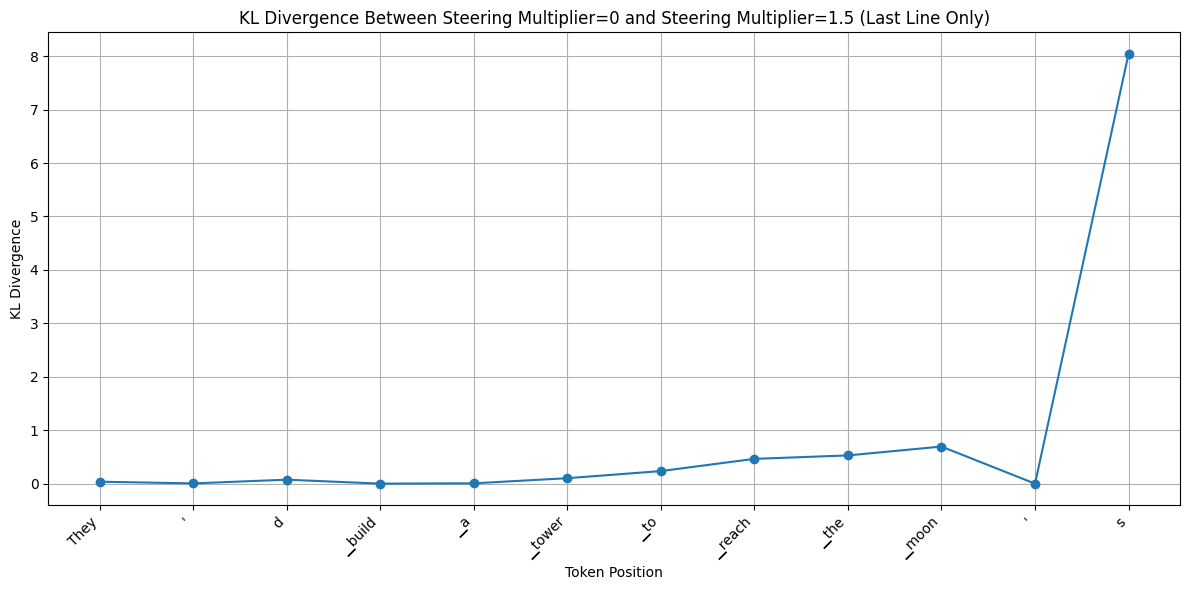

{'kl_divergences': [np.float32(0.036400583),
  np.float32(0.004590045),
  np.float32(0.07414716),
  np.float32(0.00022086177),
  np.float32(0.006095928),
  np.float32(0.101959005),
  np.float32(0.23503369),
  np.float32(0.46376404),
  np.float32(0.5281903),
  np.float32(0.6940565),
  np.float32(6.921629e-06),
  np.float32(8.04294)],
 'tokens': ['They',
  "'",
  'd',
  '▁build',
  '▁a',
  '▁tower',
  '▁to',
  '▁reach',
  '▁the',
  '▁moon',
  "'",
  's'],
 'probs_no_steering': array([[2.5587171e-17, 9.6624717e-09, 2.6557245e-10, ..., 8.8107299e-12,
         1.2050805e-11, 4.5449755e-16],
        [7.8062556e-18, 3.6321580e-08, 9.0949470e-12, ..., 7.2120088e-13,
         6.7856831e-13, 7.3725748e-17],
        [2.4286129e-17, 7.6252036e-09, 9.2148511e-15, ..., 7.5488060e-11,
         2.9558578e-11, 3.7990444e-16],
        ...,
        [5.3998350e-20, 1.7345883e-08, 8.4696694e-12, ..., 3.6859404e-14,
         5.7909233e-13, 4.1928131e-20],
        [6.0562856e-20, 1.1932570e-09, 2.9837244e-16

In [24]:
toanalyze=candidate_texts[0]
analyze_steering_impact_last_line(toanalyze,-steering_vector, layer_idx=27)

In [25]:
get_all_next_token_probs(toanalyze,0,27, steering_vector)

array([[2.69803051e-25, 1.44541264e-06, 1.14917755e-04, ...,
        1.64663205e-18, 1.45022883e-15, 6.01393393e-20],
       [5.35682609e-15, 6.71386719e-04, 4.93400876e-11, ...,
        1.71894499e-10, 2.22644303e-09, 2.23432384e-15],
       [2.65412692e-16, 1.93715096e-07, 8.33097147e-10, ...,
        3.27418093e-11, 3.78008735e-12, 4.96130914e-16],
       ...,
       [5.39983504e-20, 1.73458830e-08, 8.46966941e-12, ...,
        3.68594044e-14, 5.79092330e-13, 4.19281309e-20],
       [6.05628557e-20, 1.19325705e-09, 2.98372438e-16, ...,
        1.59594560e-16, 1.71390679e-15, 3.68459332e-20],
       [1.07202607e-21, 2.06637196e-09, 2.02060590e-14, ...,
        1.21430643e-15, 7.93809463e-15, 2.92491065e-21]],
      shape=(28, 256000), dtype=float32)

In [19]:
from typing import List, Optional
import math
# Assume apply_steering context manager is defined elsewhere and works with batches
# from your_steering_utils import apply_steering

def get_batch_next_token_probs(
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizer,
    input_texts: List[str],
    steering_multiplier: float,
    layer: int, # Layer index for steering
    steering_vector: Optional[torch.Tensor] # Steering vector (can be None)
) -> Optional[np.ndarray]:
    """
    Calculates next-token probabilities for a batch of input texts, compatible
    with the position-specific steering mechanism using global variables.

    Args:
        model: The language model.
        tokenizer: The tokenizer.
        input_texts: A list of input text strings.
        steering_multiplier: The multiplier for the steering vector.
        layer: Identifier for the layer to apply steering.
        steering_vector: The steering vector tensor, or None for no steering.

    Returns:
        A numpy array of shape (batch_size, sequence_length, vocab_size)
        containing probabilities (float32), or None if an error occurs.
    """
    global initial_input_ids_global # Declare intention to modify global

    if not input_texts:
        return np.array([]) # Return empty array for empty input

    # Check prerequisite for steering
    if steering_vector is not None and newline_token_id_global is None:
        print("Error: Steering vector provided but newline_token_id_global not set.")
        print("Call find_newline_token_id(tokenizer) first.")
        return None # Cannot proceed

    outputs = None
    batch_probs_np = None
    inputs = None # Define inputs outside try for cleanup

    try:
        # Tokenize the batch with padding
        inputs = tokenizer(
            input_texts,
            return_tensors="pt",
            padding=True,       # Pad sequences to the longest in the batch
            truncation=True,    # Truncate sequences if they exceed max model length
            return_attention_mask=True # Important for padded sequences
        ).to(model.device)

        # --- Set the global input IDs BEFORE the model call ---
        initial_input_ids_global = inputs["input_ids"]

        with torch.no_grad():
            # Conditionally apply steering context manager
            if steering_vector is not None and steering_multiplier != 0:
                 # Use apply_steering (signature unchanged)
                 with apply_steering(model, layer, steering_vector, steering_multiplier):
                     # Model call *inside* context - hook will use global input_ids
                     outputs = model(
                         input_ids=inputs["input_ids"],
                         attention_mask=inputs["attention_mask"],
                         output_hidden_states=False # Only need logits
                     )
            else:
                 # No steering, direct model call
                 outputs = model(
                     input_ids=inputs["input_ids"],
                     attention_mask=inputs["attention_mask"],
                     output_hidden_states=False
                 )

            # Check if model call was successful
            if outputs is None or not hasattr(outputs, 'logits'):
                 print("Error: Model did not return expected outputs.")
                 # Ensure global is cleared even on early exit
                 initial_input_ids_global = None
                 return None

            # Get logits: shape (batch_size, sequence_length, vocab_size)
            logits = outputs.logits
            # Convert to probabilities using softmax
            probs = torch.nn.functional.softmax(logits, dim=-1)

            # Convert to float32 before moving to CPU and NumPy
            probs_float32 = probs.to(torch.float32)

            # Move to CPU and convert to numpy
            batch_probs_np = probs_float32.cpu().numpy()

    except Exception as e:
        print(f"Error in get_batch_next_token_probs: {e}")
        batch_probs_np = None # Ensure None is returned on error
    finally:
        # --- IMPORTANT: Clear the global input IDs ---
        initial_input_ids_global = None
        # Cleanup other tensors
        del inputs, outputs
        if 'logits' in locals(): del logits
        if 'probs' in locals(): del probs
        if 'probs_float32' in locals(): del probs_float32
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    return batch_probs_np

In [20]:
from typing import List, Tuple
BATCH_SIZE=1000
def filter_high_kl_texts(
    texts: List[str],
    steering_vector: torch.Tensor,
    output_dir: str = "kl_plots",
    layer_idx: int = 20, # Layer identifier for steering
    kl_threshold: float = 1.0,
    visualize: bool = False,
    model = model, # Pass model and tokenizer explicitly
    tokenizer = tokenizer
    ) -> Tuple[List[str], List[List[str]], List[List[float]]]: # Added return type hint
    """
    Filter texts where KL divergence exceeds a threshold *at any position corresponding
    to a token within the last line*, using batch processing. Plots cover the full last line.
    Saves KL divergence plots to specified directory if visualize=True.

    Args:
        texts: List of input text strings.
        steering_vector: The steering vector to use.
        output_dir: Directory to save the KL divergence plots.
        layer_idx: Which transformer layer to apply steering.
        kl_threshold: The KL divergence threshold to trigger filtering.
        visualize: Whether to generate and save plots for high KL texts.
        model: The language model.
        tokenizer: The tokenizer.

    Returns:
        Tuple containing:
        - List of texts where KL divergence > threshold occurs for any token in the last line.
        - List of corresponding last line tokens (strings) for those texts.
        - List of corresponding KL divergence lists (one value per token in the last line).
    """
    if model is None or tokenizer is None:
        raise ValueError("Model and tokenizer must be provided.")

    os.makedirs(output_dir, exist_ok=True)
    print(f"Processing {len(texts)} texts. Saving plots (if enabled) to: {output_dir}")

    high_kl_texts = []
    high_kl_text_tokens = []
    high_kl_divergences = []

    # Process texts in batches
    for i in range(0, len(texts), BATCH_SIZE):
        batch_texts = texts[i : i + BATCH_SIZE]
        if not batch_texts: continue

        # Get batched probability distributions
        batch_probs_no_steering = get_batch_next_token_probs(
            model, tokenizer, batch_texts, 0, layer_idx, steering_vector
        )
        batch_probs_with_steering = get_batch_next_token_probs(
            model, tokenizer, batch_texts, 1.5, layer_idx, steering_vector
        )

        if batch_probs_no_steering is None or batch_probs_with_steering is None:
            print(f"Warning: Skipping batch starting at index {i} due to probability error.")
            continue

        # --- Process results for each text WITHIN the batch ---
        for k in range(len(batch_texts)):
            current_text = batch_texts[k]
            # Get the full probability sequences for this item from the batch
            # Shape: (padded_seq_len, vocab_size)
            probs_no_steering_full = batch_probs_no_steering[k]
            probs_with_steering_full = batch_probs_with_steering[k]
            prob_seq_len = probs_no_steering_full.shape[0] # Length including padding

            try:
                # Tokenize individual text to get actual length and token IDs
                full_tokens_info = tokenizer(current_text)
                full_token_ids = full_tokens_info.input_ids
                actual_seq_len = len(full_token_ids) # Unpadded length

                last_newline_pos = current_text.rfind('\n')
        
                # If there's a newline, take only the text after it; otherwise, use the entire text
                if last_newline_pos != -1:
                    last_line = current_text[last_newline_pos + 1:]
                    #print(f"Processing the last line: '{last_line}'")
                else:
                    last_line = current_text
                    print(f"Warning: No last line for text index {i+k}. Skipping.")
                    continue

                # Tokenize last line (without special tokens) to get its tokens and length
                last_line_tokenization = tokenizer(last_line, add_special_tokens=False)
                last_line_token_ids_only = last_line_tokenization.input_ids
                last_line_tokens_str = tokenizer.convert_ids_to_tokens(last_line_token_ids_only)
                num_last_line_tokens = len(last_line_token_ids_only)

                if num_last_line_tokens <= 0:
                    print(f"Warning: Last line resulted in 0 tokens for text index {i+k}. Skipping.")
                    continue

                # --- Corrected Index Calculation ---
                # Find the start index of the last line within the *full* unpadded tokenization
                # This assumes the last num_last_line_tokens are the last line.
                # A robust search might be needed if tokenization inconsistencies exist.
                last_line_token_start_index_in_full = actual_seq_len - num_last_line_tokens

                # The probability distribution needed to predict the *first* token of the last line
                # comes from the output of the token *before* it.
                prob_slice_start_index = -num_last_line_tokens #last_line_token_start_index_in_full

                # The probability distribution needed to predict the *last* token of the last line
                # comes from the output of the second-to-last token of the last line.
                # The index for this is (last_line_token_start_index_in_full + num_last_line_tokens - 1) - 1
                #prob_slice_end_index = -1#last_line_token_start_index_in_full + num_last_line_tokens # Exclusive end index

                # --- Boundary Checks ---
                #if prob_slice_start_index < 0:
                #    print(f"Warning: Calculated probability start index ({prob_slice_start_index}) is invalid for text index {i+k}. Skipping.")
                #    continue
                #if prob_slice_end_index > prob_seq_len: # Compare against padded length from prob array
                #     print(f"Warning: Calculated probability slice end ({prob_slice_end_index}) exceeds prob array length ({prob_seq_len}) for text index {i+k}. Truncating analysis.")
                #     prob_slice_end_index = prob_seq_len
                #     # Adjust the number of tokens we can analyze if truncated
                #     num_effective_tokens = prob_slice_end_index - prob_slice_start_index
                #     if num_effective_tokens != num_last_line_tokens:
                #          print(f"  -> Analyzing only {num_effective_tokens} token predictions.")
                #          # Adjust token strings list to match the number of KL values we can compute
                #          if num_effective_tokens < 0: continue # Cannot proceed
                #          last_line_tokens_str = last_line_tokens_str[:num_effective_tokens]
                #          if not last_line_tokens_str: continue
                #elif (prob_slice_end_index - prob_slice_start_index) != num_last_line_tokens:
                #     # This case should ideally not happen with correct logic, but is a sanity check
                #     print(f"Warning: Mismatch between expected slice length ({num_last_line_tokens}) and calculated slice length ({prob_slice_end_index - prob_slice_start_index}) for text index {i+k}. Skipping.")
                #     continue


                # --- Slice Probabilities ---
                # Slice the probability arrays using the corrected indices
                # The length of this slice should now be num_last_line_tokens (or fewer if truncated)
                last_line_pred_probs_no_steering = probs_no_steering_full[prob_slice_start_index:, :]
                last_line_pred_probs_with_steering = probs_with_steering_full[prob_slice_start_index:, :]

                # --- Calculate KL Divergence for each token prediction ---
                #if last_line_pred_probs_no_steering.shape[0] != len(last_line_tokens_str):
                #    print(f"Warning: Mismatch between number of probabilities ({last_line_pred_probs_no_steering.shape[0]}) and tokens ({len(last_line_tokens_str)}) for text index {i+k}. Skipping.")
                #    continue

                kl_divergences = []
                for t in range(last_line_pred_probs_no_steering.shape[0]): # Iterate over the predictions for tokens in the last line
                    kl_div = calculate_kl_divergence(
                        last_line_pred_probs_with_steering[t], # P (prediction with steering)
                        last_line_pred_probs_no_steering[t]    # Q (prediction without steering)
                    )
                    if not math.isfinite(kl_div): kl_div = np.nan
                    kl_divergences.append(kl_div)

                # --- Check Condition ---
                # Check if *any* KL value in the list (corresponding to any token prediction within the last line) exceeds the threshold
                # No need to exclude the last one now, as we want to check the prediction for every token *in* the line.
                if any(kl > kl_threshold for kl in kl_divergences if not np.isnan(kl)):
                    high_kl_texts.append(current_text)
                    high_kl_text_tokens.append(last_line_tokens_str) # Full list of tokens in the line
                    high_kl_divergences.append(kl_divergences)       # Full list of KLs for the line

                    # --- Visualization (if enabled) ---
                    if visualize:
                        plt.figure(figsize=(max(12, len(last_line_tokens_str)*0.6), 6)) # Dynamic width
                        plot_indices = [idx for idx, kl in enumerate(kl_divergences) if not np.isnan(kl)]
                        plot_kls = [kl_divergences[idx] for idx in plot_indices]
                        plot_tokens = [last_line_tokens_str[idx] for idx in plot_indices]

                        if plot_indices:
                             plt.plot(plot_indices, plot_kls, marker='o', linestyle='-')
                             plt.title(f'KL Divergence (Steering 1.5 vs 0) - Predictions for Last Line Tokens\nText starts: {current_text[:50]}...')
                             plt.xlabel('Predicted Token Position in Last Line (0 = first token, etc.)')
                             plt.ylabel('KL Divergence')
                             #plt.axhline(kl_threshold, color='r', linestyle='--', label=f'Threshold ({kl_threshold})') # Add threshold line
                             plt.grid(True)
                             # Use the tokens corresponding to the plotted KL values
                             plt.xticks(plot_indices, plot_tokens, rotation=60, ha='right', fontsize=9)
                             #plt.legend()
                             plt.tight_layout()

                             #safe_text = "".join(x for x in current_text[:30] if x.isalnum()) or f"text_{i+k}"
                             plt.savefig(os.path.join(output_dir, f'kl_divergence_example_{k}_{current_text}.png'))
                        else:
                             print(f"Info: No valid KL values to plot for text index {i+k}.")
                        plt.close() # Close plot

            except Exception as e_inner:
                print(f"Error processing text index {i+k} within batch: {e_inner}")

    print(f"Finished processing. Found {len(high_kl_texts)} texts with KL > {kl_threshold} for at least one token prediction in the last line.")
    return high_kl_texts, high_kl_text_tokens, high_kl_divergences

In [21]:
test_texts = candidate_texts

In [21]:
# Test filter_high_kl_texts on a small sample


layer_idx = 27
high_kl_results, high_kl_text_tokens, high_kl_divergences = filter_high_kl_texts(test_texts[:8], -steering_vector,layer_idx=27,visualize=True)
print(f"Found {len(high_kl_results)} texts with high KL divergence:")
for text in high_kl_results:
    print(f"\n{text}")


Processing 8 texts. Saving plots (if enabled) to: kl_plots
Error: Steering vector provided but newline_token_id_global not set.
Call find_newline_token_id(tokenizer) first.
Error: Steering vector provided but newline_token_id_global not set.
Call find_newline_token_id(tokenizer) first.
Finished processing. Found 0 texts with KL > 1.0 for at least one token prediction in the last line.
Found 0 texts with high KL divergence:


In [ ]:
high_kl_results[2]

In [ ]:
high_kl_divergences[2]

In [25]:
#real deal
high_kl_results, high_kl_text_tokens, high_kl_divergences = filter_high_kl_texts(test_texts, -steering_vector,layer_idx = 27,visualize=True)
print(f"Found {len(high_kl_results)} texts with high KL divergence:")
for text in high_kl_results:
    print(f"\n{text}")

Processing 481 texts. Saving plots (if enabled) to: kl_plots
Finished processing. Found 424 texts with KL > 1.0 for at least one token prediction in the last line.
Found 424 texts with high KL divergence:

A rhymed couplet:
The plan they proposed was utterly insane
They'd build a tower to reach the moon's

A rhymed couplet:
The plan they proposed was utterly insane
And filled with peril, a recipe for

A rhymed couplet:
The plan they proposed was utterly insane
To climb the mountain, through pouring

A rhymed couplet:
The plan they proposed was utterly insane
Their logic flawed, their vision all in

A rhymed couplet:
The plan they proposed was utterly insane
And sure to end in chaos and in

A rhymed couplet:
The plan they proposed was utterly insane
And doomed to fail from the very start, in

A rhymed couplet:
The plan they proposed was utterly insane
And bound to cause nothing but endless

A rhymed couplet:
The plan they proposed was utterly insane
And their dreams were nothing but a w

In [33]:
print(high_kl_results[0])
print(high_kl_text_tokens[0])
print(high_kl_divergences[0])

A rhymed couplet:
The plan they proposed was utterly insane
They'd build a tower to reach the moon's
['They', "'", 'd', '▁build', '▁a', '▁tower', '▁to', '▁reach', '▁the', '▁moon', "'", 's']
[np.float32(0.03655274), np.float32(0.00630405), np.float32(0.06931877), np.float32(0.00013036602), np.float32(0.0069834027), np.float32(0.09025318), np.float32(0.20992135), np.float32(0.49675062), np.float32(0.4656313), np.float32(0.65650785), np.float32(6.164312e-06), np.float32(8.017668)]


====Prompt:====
A rhymed couplet:
The plan they proposed was utterly insane
They'd build a tower to reach the moon's
Processing the last line: 'They'd build a tower to reach the moon's'
Processing with steering_multiplier=0...
Processing with steering_multiplier=1.5...


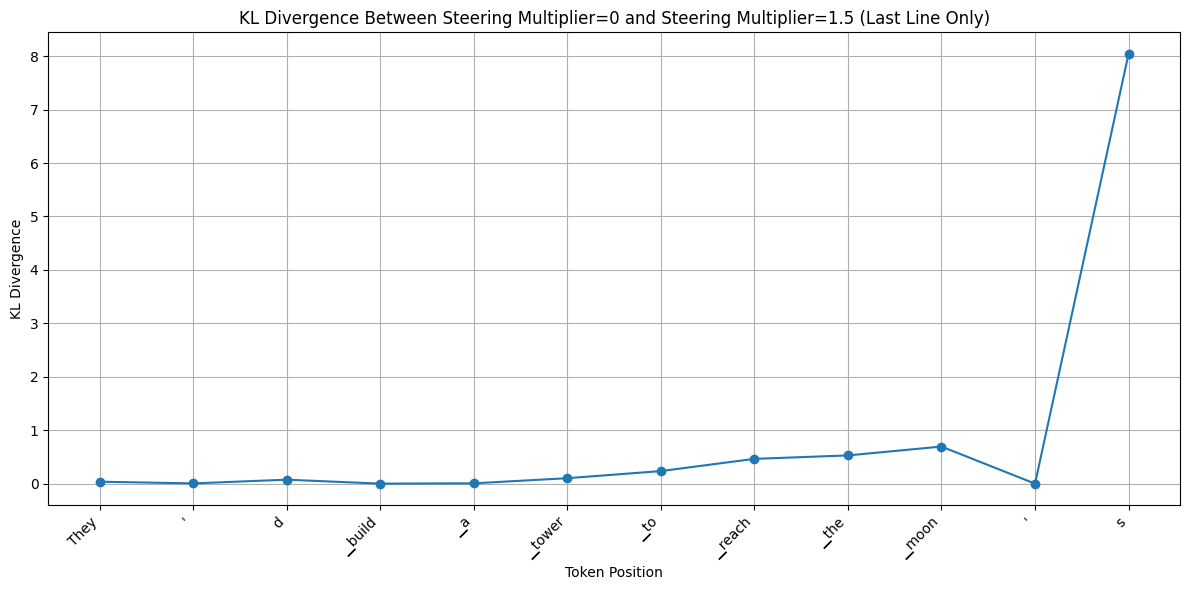

{'kl_divergences': [np.float32(0.036400583),
  np.float32(0.004590045),
  np.float32(0.07414716),
  np.float32(0.00022086177),
  np.float32(0.006095928),
  np.float32(0.101959005),
  np.float32(0.23503369),
  np.float32(0.46376404),
  np.float32(0.5281903),
  np.float32(0.6940565),
  np.float32(6.921629e-06),
  np.float32(8.04294)],
 'tokens': ['They',
  "'",
  'd',
  '▁build',
  '▁a',
  '▁tower',
  '▁to',
  '▁reach',
  '▁the',
  '▁moon',
  "'",
  's'],
 'probs_no_steering': array([[2.5587171e-17, 9.6624717e-09, 2.6557245e-10, ..., 8.8107299e-12,
         1.2050805e-11, 4.5449755e-16],
        [7.8062556e-18, 3.6321580e-08, 9.0949470e-12, ..., 7.2120088e-13,
         6.7856831e-13, 7.3725748e-17],
        [2.4286129e-17, 7.6252036e-09, 9.2148511e-15, ..., 7.5488060e-11,
         2.9558578e-11, 3.7990444e-16],
        ...,
        [5.3998350e-20, 1.7345883e-08, 8.4696694e-12, ..., 3.6859404e-14,
         5.7909233e-13, 4.1928131e-20],
        [6.0562856e-20, 1.1932570e-09, 2.9837244e-16

In [167]:
analyze_steering_impact_last_line(high_kl_results[0],-steering_vector,layer_idx=27)

In [22]:
#doesn't do batching well - use the version below
from collections import defaultdict
# --- Configuration ---
GPU_BATCH_SIZE = 1000       # How many prefixes to process in one model.generate call. TUNE THIS based on VRAM and sequence lengths.
NUM_CONTINUATIONS = 100   # Number of rollouts per prefix
MAX_GEN_TOKENS = 25       # Max new tokens for generation
TEMPERATURE = 0.7         # Generation temperature
DO_SAMPLE = True          # Use sampling

# --- Modified Function ---
def clean(f):
    f=f.strip('.')
    f=f.strip(',')
    f=f.strip('!')
    return f

def calculate_target_token_frequencies_batched(
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizer,
    candidate_texts: List[str],
    candidate_last_tokens: List[str], # Target words for each text
    newline_token_id: int,          # Pre-calculated newline token ID
    device: torch.device, # Keep device arg, though generate_steered_output handles internal placement
    # Add generation parameters needed by generate_steered_output
    max_new_tokens: int = MAX_GEN_TOKENS,
    temperature: float = TEMPERATURE,
    do_sample: bool = DO_SAMPLE,
    debug=False    
) -> List[List[float]]:
    """
    Calculates the frequency of target tokens appearing as the last word
    in generated continuations for prefixes after the last newline in each text.
    Uses length sorting and delegates generation entirely to generate_steered_output.
    Removes internal batching loop and tqdm.

    Args:
        model: The language model.
        tokenizer: The tokenizer.
        candidate_texts: List of input text strings.
        candidate_last_tokens: List of target last words corresponding to candidate_texts.
        newline_token_id: The token ID for the newline character.
        device: The torch device (mostly informational now).
        max_new_tokens, temperature, do_sample: Generation parameters.


    Returns:
        A list of lists, where each inner list contains the frequencies
        (matches/NUM_CONTINUATIONS) for each token position after the last newline
        in the corresponding input text.
    """
    if not candidate_texts or not candidate_last_tokens or len(candidate_texts) != len(candidate_last_tokens):
        raise ValueError("Input lists are empty or have mismatched lengths.")
    if newline_token_id is None:
        raise ValueError("newline_token_id must be provided.")

    candidate_last_tokens=[clean(w) for w in candidate_last_tokens]
    model.eval() # Ensure model is in eval mode
    original_padding_side = tokenizer.padding_side
    # generate_steered_output should handle padding side internally

    all_prefixes_data = [] # Stores tuples: (original_text_idx, pos_in_text, prefix_token_ids, target_token)

    print("Step 1: Collecting prefixes...")
    # (Prefix collection logic remains the same)
    for text_idx, (text, target_token) in enumerate(zip(candidate_texts, candidate_last_tokens)):
        try:
             tokens_tensor = tokenizer(text, return_tensors="pt", add_special_tokens=False).input_ids[0]
             tokens_list = tokens_tensor.tolist()
        except Exception as e:
             print(f"Warning: Error tokenizing text index {text_idx}: {e}. Skipping.")
             continue
        try:
            newline_indices_rev = [i for i, token_id in enumerate(reversed(tokens_list)) if token_id == newline_token_id]
            last_n_pos = len(tokens_list) - 1 - newline_indices_rev[0] if newline_indices_rev else -1
        except Exception as e:
            print(f"Warning: Error finding newline in text index {text_idx}: {e}. Skipping.")
            continue
        for pos_idx in range(last_n_pos + 1, len(tokens_list)):
            prefix_tokens = tokens_list[:pos_idx]
            if not prefix_tokens: continue
            all_prefixes_data.append(
                (text_idx, pos_idx, torch.tensor(prefix_tokens, dtype=torch.long), target_token)
            )
    # --- End Prefix Collection ---

    if not all_prefixes_data:
        print("No valid prefixes found to generate from.")
        # tokenizer.padding_side = original_padding_side # Restore if needed
        return [[] for _ in candidate_texts]

    print(f"Collected {len(all_prefixes_data)} total prefixes.")

    # Step 2: Sort prefixes by length
    print("Step 2: Sorting prefixes by length...")
    all_prefixes_data.sort(key=lambda x: len(x[2]))

    # Step 3: Decode all sorted prefixes and generate using generate_steered_output ONCE
    print(f"Step 3: Decoding {len(all_prefixes_data)} prefixes...")
    all_prefix_strings_sorted = [tokenizer.decode(data[2]) for data in all_prefixes_data]

    print(f"Step 3b: Calling generate_steered_output for all {len(all_prefix_strings_sorted)} prefixes (generating {NUM_CONTINUATIONS} each)...")
    all_generated_texts = []
    try:
        # Call generate_steered_output for the *entire sorted list* of prefix strings
        all_generated_texts = generate_steered_output(
            steering_vector=None, # No steering needed for this specific task
            model=model,
            tokenizer=tokenizer,
            generation_prompts=all_prefix_strings_sorted, # Pass the full sorted list
            batch_size=NUM_CONTINUATIONS,                # Generate 100 outputs per prefix
            # Pass other necessary args
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=do_sample
            # layer=..., steering_multiplier=... # Only if steering needed
        )
        print("Generation complete.")
    except Exception as e:
         print(f"Error during the single call to generate_steered_output: {e}")
         # Depending on the error, you might have partial results or none
         # If no results, return empty structure
         if not all_generated_texts:
              print("No results generated due to error.")
              tokenizer.padding_side = original_padding_side
              return [[] for _ in candidate_texts]
         else:
              print("Proceeding with potentially incomplete results due to error.")

    # --- Step 3c: Process Results ---
    print("Step 3c: Processing generated texts...")
    temp_results = {} # Key: (text_idx, pos_idx), Value: frequency
    expected_num_outputs = len(all_prefix_strings_sorted) * NUM_CONTINUATIONS

    if len(all_generated_texts) != expected_num_outputs:
        print(f"Warning: Mismatch in expected outputs!")
        print(f"  Expected {expected_num_outputs}, got {len(all_generated_texts)}. Results might be incomplete or incorrect.")
        # Attempt to process what we have, but mapping might be wrong if generation failed mid-way

    output_idx_counter = 0
    # Iterate through the *sorted* prefix data which corresponds to the order of generation
    for k in range(len(all_prefixes_data)):
        text_idx, pos_idx, _, target_token = all_prefixes_data[k] # Get original metadata
        
        matches = 0
        # Extract the NUM_CONTINUATIONS corresponding to this k-th prefix
        start_idx = k * NUM_CONTINUATIONS
        end_idx = start_idx + NUM_CONTINUATIONS

        # Check bounds in case of generation error / mismatch
        if start_idx >= len(all_generated_texts):
             print(f"Warning: Ran out of generated texts while processing prefix index {k}. Skipping.")
             continue
        # Adjust end_idx if generation was cut short
        actual_end_idx = min(end_idx, len(all_generated_texts))

        prefix_continuations = all_generated_texts[start_idx:actual_end_idx]
        actual_num_continuations = len(prefix_continuations) # Use actual count for frequency calc

        for cont in prefix_continuations:
            last_word = get_last_word(cont)
            last_word=clean(last_word)
            if debug:
                print(f"Generated text: {cont}")
                print(f"Checking the match between last word {last_word} and target {target_token}")
            if last_word == target_token:
                matches += 1

        # Calculate and store frequency (use actual count if generation was partial)
        frequency = matches / actual_num_continuations if actual_num_continuations > 0 else 0.0
        temp_results[(text_idx, pos_idx)] = frequency

    # Minimal cleanup
    del all_prefix_strings_sorted, all_generated_texts, all_prefixes_data
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Step 4: Assemble Final Output Structure
    print("Step 4: Assembling final results...")
    # (Assembly logic remains the same)
    target_token_frequencies = [[] for _ in candidate_texts]
    grouped_results = defaultdict(list)
    for (text_idx, pos_idx), frequency in temp_results.items():
        grouped_results[text_idx].append((pos_idx, frequency))
    for text_idx in range(len(candidate_texts)):
        if text_idx in grouped_results:
            sorted_freqs = sorted(grouped_results[text_idx], key=lambda x: x[0])
            target_token_frequencies[text_idx] = [freq for pos, freq in sorted_freqs]
    # --- End Assembly ---

    print("Processing complete.")
    tokenizer.padding_side = original_padding_side # Restore original padding side
    return target_token_frequencies

In [23]:
#NEW VERSION WITH BATCHING
PREFIX_BATCH_SIZE = 16

NUM_CONTINUATIONS = 100   # Number of rollouts per prefix (passed as batch_size to generate_steered_output)
MAX_GEN_TOKENS = 25       # Max new tokens for generation
TEMPERATURE = 0.7         # Generation temperature
DO_SAMPLE = True          # Use sampling

def clean(f):
    f=f.strip('.')
    f=f.strip(',')
    f=f.strip('!')
    return f
# --- Modified Function ---

def calculate_target_token_frequencies_batched(
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizer,
    candidate_texts: List[str],
    candidate_last_tokens: List[str], # Target words for each text
    newline_token_id: int,          # Pre-calculated newline token ID
    device: torch.device, # Keep device arg
    # Add generation parameters needed by generate_steered_output
    max_new_tokens: int = MAX_GEN_TOKENS,
    temperature: float = TEMPERATURE,
    do_sample: bool = DO_SAMPLE,
    debug=False
) -> List[List[float]]:
    """
    Calculates the frequency of target tokens appearing as the last word
    in generated continuations for prefixes after the last newline in each text.
    Uses length sorting and calls generate_steered_output in manageable batches.

    Args:
        model: The language model.
        tokenizer: The tokenizer.
        candidate_texts: List of input text strings.
        candidate_last_tokens: List of target last words corresponding to candidate_texts.
        newline_token_id: The token ID for the newline character.
        device: The torch device.
        max_new_tokens, temperature, do_sample: Generation parameters.
        debug: Flag for verbose printing during matching.


    Returns:
        A list of lists, where each inner list contains the frequencies
        (matches/NUM_CONTINUATIONS) for each token position after the last newline
        in the corresponding input text.
    """
    if not candidate_texts or not candidate_last_tokens or len(candidate_texts) != len(candidate_last_tokens):
        raise ValueError("Input lists are empty or have mismatched lengths.")
    if newline_token_id is None:
        raise ValueError("newline_token_id must be provided.")

    # Clean target tokens once at the beginning
    cleaned_candidate_last_tokens = [clean(w) for w in candidate_last_tokens]

    model.eval() # Ensure model is in eval mode
    original_padding_side = tokenizer.padding_side
    # generate_steered_output should handle padding side internally if needed

    all_prefixes_data = [] # Stores tuples: (original_text_idx, pos_in_text, prefix_token_ids, target_token)

    print("Step 1: Collecting prefixes...")
    # --- Prefix Collection (No changes needed here) ---
    for text_idx, (text, target_token) in enumerate(zip(candidate_texts, cleaned_candidate_last_tokens)): # Use cleaned targets
        try:
             tokens_tensor = tokenizer(text, return_tensors="pt", add_special_tokens=False).input_ids[0]
             tokens_list = tokens_tensor.tolist()
        except Exception as e:
             print(f"Warning: Error tokenizing text index {text_idx}: {e}. Skipping.")
             continue
        try:
            newline_indices_rev = [i for i, token_id in enumerate(reversed(tokens_list)) if token_id == newline_token_id]
            last_n_pos = len(tokens_list) - 1 - newline_indices_rev[0] if newline_indices_rev else -1
        except Exception as e:
            print(f"Warning: Error finding newline in text index {text_idx}: {e}. Skipping.")
            continue
        for pos_idx in range(last_n_pos + 1, len(tokens_list)):
            prefix_tokens = tokens_list[:pos_idx]
            if not prefix_tokens: continue
            all_prefixes_data.append(
                (text_idx, pos_idx, torch.tensor(prefix_tokens, dtype=torch.long), target_token)
            )
    # --- End Prefix Collection ---

    if not all_prefixes_data:
        print("No valid prefixes found to generate from.")
        return [[] for _ in candidate_texts]

    print(f"Collected {len(all_prefixes_data)} total prefixes.")

    # Step 2: Sort prefixes by length
    print("Step 2: Sorting prefixes by length...")
    all_prefixes_data.sort(key=lambda x: len(x[2]))

    # Step 3: Process Prefixes in Batches
    print(f"Step 3: Generating continuations in batches of {PREFIX_BATCH_SIZE} prefixes...")
    temp_results = {} # Key: (text_idx, pos_idx), Value: frequency

    # --- Reintroduce Batch Loop ---
    num_prefixes = len(all_prefixes_data)
    for i in range(0, num_prefixes, PREFIX_BATCH_SIZE):
        batch_start_idx = i
        batch_end_idx = min(i + PREFIX_BATCH_SIZE, num_prefixes)
        current_batch_data = all_prefixes_data[batch_start_idx:batch_end_idx]
        if not current_batch_data: continue

        print(f"  Processing prefix batch {i // PREFIX_BATCH_SIZE + 1} / {math.ceil(num_prefixes / PREFIX_BATCH_SIZE)} (indices {batch_start_idx}-{batch_end_idx-1})")

        # Decode prefixes for this batch only
        batch_prefix_strings = [tokenizer.decode(data[2]) for data in current_batch_data]

        # Call generate_steered_output for the current batch of prefixes
        batch_generated_texts = []
        try:
            batch_generated_texts = generate_steered_output(
                steering_vector=None, # No steering needed for this specific task
                model=model,
                tokenizer=tokenizer,
                generation_prompts=batch_prefix_strings, # Pass the current batch list
                batch_size=NUM_CONTINUATIONS,          # Generate N outputs per prefix
                # Pass other necessary args
                max_new_tokens=max_new_tokens,
                temperature=temperature,
                do_sample=do_sample
                # layer=..., steering_multiplier=... # Only if steering needed
            )
            if debug: print(f"    Generated {len(batch_generated_texts)} texts for this batch.")

        except Exception as e:
             print(f"Error during call to generate_steered_output for batch starting at prefix index {i}: {e}")
             # Decide how to handle: skip batch, retry, etc. Skipping result processing for this batch.
             continue # Move to the next batch

        # --- Process results for THIS batch ---
        expected_num_outputs = len(batch_prefix_strings) * NUM_CONTINUATIONS
        if len(batch_generated_texts) != expected_num_outputs:
            print(f"Warning: Mismatch in expected outputs for batch starting at {i}.")
            print(f"  Expected {expected_num_outputs}, got {len(batch_generated_texts)}. Processing available results.")
            # Attempt to process what we have, but mapping might be wrong if generation failed mid-way

        output_idx_counter = 0
        # Iterate through the prefixes *in this batch*
        for k in range(len(current_batch_data)):
            text_idx, pos_idx, _, target_token = current_batch_data[k] # Get original metadata

            matches = 0
            # Extract the NUM_CONTINUATIONS corresponding to this k-th prefix *within the batch results*
            start_idx_in_batch_results = k * NUM_CONTINUATIONS
            end_idx_in_batch_results = start_idx_in_batch_results + NUM_CONTINUATIONS

            # Check bounds against the actual number of texts returned *for this batch*
            if start_idx_in_batch_results >= len(batch_generated_texts):
                if k==0: # Only warn once per batch if generation completely failed
                     print(f"Warning: No generated texts available for batch starting at prefix index {i}. Skipping results processing for this batch.")
                break # Exit inner loop for this batch if results are missing

            actual_end_idx = min(end_idx_in_batch_results, len(batch_generated_texts))
            prefix_continuations = batch_generated_texts[start_idx_in_batch_results:actual_end_idx]
            actual_num_continuations = len(prefix_continuations)

            for cont_idx, cont in enumerate(prefix_continuations):
                last_word = get_last_word(cont)
                last_word = clean(last_word) # Apply cleaning
                if debug and cont_idx < 2: # Print first few checks per prefix if debugging
                    print(f"    [Batch {i//PREFIX_BATCH_SIZE+1}, Prefix {k}, Rollout {cont_idx}] Gen text: '{cont[:50]}...' -> Last word: '{last_word}', Target: '{target_token}'")
                if last_word == target_token:
                    matches += 1

            # Calculate and store frequency
            frequency = matches / actual_num_continuations if actual_num_continuations > 0 else 0.0
            temp_results[(text_idx, pos_idx)] = frequency

        # Minimal cleanup for the batch
        del current_batch_data, batch_prefix_strings, batch_generated_texts
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    # --- End Batch Loop ---

    # Free memory from original large list
    del all_prefixes_data
    gc.collect()

    # Step 4: Assemble Final Output Structure
    print("Step 4: Assembling final results...")
    # (Assembly logic remains the same)
    target_token_frequencies = [[] for _ in candidate_texts]
    grouped_results = defaultdict(list)
    for (text_idx, pos_idx), frequency in temp_results.items():
        grouped_results[text_idx].append((pos_idx, frequency))
    for text_idx in range(len(candidate_texts)):
        if text_idx in grouped_results:
            sorted_freqs = sorted(grouped_results[text_idx], key=lambda x: x[0])
            target_token_frequencies[text_idx] = [freq for pos, freq in sorted_freqs]
    # --- End Assembly ---

    print("Processing complete.")
    tokenizer.padding_side = original_padding_side # Restore original padding side
    return target_token_frequencies

In [38]:
datasofar={"couplets":high_kl_results,
"final_tokens": token_for_high_kl,
"tokenizations": high_kl_text_tokens,
"KL_divergences_when_steering": [[float(k) for k in kldiv] for kldiv in high_kl_divergences]}

In [39]:
with open("KL_divergences_for_pain_rhymes",'w') as f:
    json.dump(datasofar,f)

In [24]:
with open("KL_divergences_for_pain_rhymes",'r') as f:
    KL_divergences_for_pain_rhymes=json.load(f)

In [25]:
high_kl_results=KL_divergences_for_pain_rhymes["couplets"]
high_kl_divergences=KL_divergences_for_pain_rhymes["KL_divergences_when_steering"]
token_for_high_kl=KL_divergences_for_pain_rhymes["final_tokens"]
high_kl_text_tokens=KL_divergences_for_pain_rhymes["tokenizations"]

In [26]:
suggested_token={}
for i,j in zip(candidate_texts,candidate_last_tokens):
    suggested_token[i]=j
token_for_high_kl=[suggested_token[t] for t in high_kl_results]

In [27]:
len(high_kl_results)

424

In [28]:
#throws OOM if trying to use large batches >=20
frequencies = calculate_target_token_frequencies_batched(
         model,
         tokenizer,
         high_kl_results,
         token_for_high_kl,
         newline_token_id,
         device, debug=False
     )

Step 1: Collecting prefixes...
Collected 3566 total prefixes.
Step 2: Sorting prefixes by length...
Step 3: Generating continuations in batches of 16 prefixes...
  Processing prefix batch 1 / 223 (indices 0-15)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.51s/it]


  Processing prefix batch 2 / 223 (indices 16-31)


Generating Batches: 100%|██████████| 1/1 [00:12<00:00, 12.97s/it]


  Processing prefix batch 3 / 223 (indices 32-47)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.01s/it]


  Processing prefix batch 4 / 223 (indices 48-63)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.06s/it]


  Processing prefix batch 5 / 223 (indices 64-79)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.49s/it]


  Processing prefix batch 6 / 223 (indices 80-95)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.44s/it]


  Processing prefix batch 7 / 223 (indices 96-111)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.47s/it]


  Processing prefix batch 8 / 223 (indices 112-127)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.52s/it]


  Processing prefix batch 9 / 223 (indices 128-143)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.53s/it]


  Processing prefix batch 10 / 223 (indices 144-159)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.53s/it]


  Processing prefix batch 11 / 223 (indices 160-175)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.53s/it]


  Processing prefix batch 12 / 223 (indices 176-191)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.55s/it]


  Processing prefix batch 13 / 223 (indices 192-207)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.58s/it]


  Processing prefix batch 14 / 223 (indices 208-223)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.56s/it]


  Processing prefix batch 15 / 223 (indices 224-239)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.57s/it]


  Processing prefix batch 16 / 223 (indices 240-255)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.58s/it]


  Processing prefix batch 17 / 223 (indices 256-271)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.59s/it]


  Processing prefix batch 18 / 223 (indices 272-287)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.58s/it]


  Processing prefix batch 19 / 223 (indices 288-303)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.57s/it]


  Processing prefix batch 20 / 223 (indices 304-319)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.93s/it]


  Processing prefix batch 21 / 223 (indices 320-335)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.82s/it]


  Processing prefix batch 22 / 223 (indices 336-351)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.80s/it]


  Processing prefix batch 23 / 223 (indices 352-367)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.83s/it]


  Processing prefix batch 24 / 223 (indices 368-383)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.81s/it]


  Processing prefix batch 25 / 223 (indices 384-399)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.75s/it]


  Processing prefix batch 26 / 223 (indices 400-415)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.74s/it]


  Processing prefix batch 27 / 223 (indices 416-431)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.76s/it]


  Processing prefix batch 28 / 223 (indices 432-447)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.79s/it]


  Processing prefix batch 29 / 223 (indices 448-463)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.79s/it]


  Processing prefix batch 30 / 223 (indices 464-479)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.81s/it]


  Processing prefix batch 31 / 223 (indices 480-495)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.80s/it]


  Processing prefix batch 32 / 223 (indices 496-511)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.80s/it]


  Processing prefix batch 33 / 223 (indices 512-527)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.83s/it]


  Processing prefix batch 34 / 223 (indices 528-543)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.82s/it]


  Processing prefix batch 35 / 223 (indices 544-559)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.81s/it]


  Processing prefix batch 36 / 223 (indices 560-575)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.83s/it]


  Processing prefix batch 37 / 223 (indices 576-591)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.80s/it]


  Processing prefix batch 38 / 223 (indices 592-607)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.82s/it]


  Processing prefix batch 39 / 223 (indices 608-623)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.81s/it]


  Processing prefix batch 40 / 223 (indices 624-639)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.81s/it]


  Processing prefix batch 41 / 223 (indices 640-655)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.80s/it]


  Processing prefix batch 42 / 223 (indices 656-671)


Generating Batches: 100%|██████████| 1/1 [00:13<00:00, 13.79s/it]


  Processing prefix batch 43 / 223 (indices 672-687)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.22s/it]


  Processing prefix batch 44 / 223 (indices 688-703)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.14s/it]


  Processing prefix batch 45 / 223 (indices 704-719)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.12s/it]


  Processing prefix batch 46 / 223 (indices 720-735)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.13s/it]


  Processing prefix batch 47 / 223 (indices 736-751)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.11s/it]


  Processing prefix batch 48 / 223 (indices 752-767)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.14s/it]


  Processing prefix batch 49 / 223 (indices 768-783)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.14s/it]


  Processing prefix batch 50 / 223 (indices 784-799)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.12s/it]


  Processing prefix batch 51 / 223 (indices 800-815)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.18s/it]


  Processing prefix batch 52 / 223 (indices 816-831)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.19s/it]


  Processing prefix batch 53 / 223 (indices 832-847)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.17s/it]


  Processing prefix batch 54 / 223 (indices 848-863)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.19s/it]


  Processing prefix batch 55 / 223 (indices 864-879)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.17s/it]


  Processing prefix batch 56 / 223 (indices 880-895)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.16s/it]


  Processing prefix batch 57 / 223 (indices 896-911)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.19s/it]


  Processing prefix batch 58 / 223 (indices 912-927)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.18s/it]


  Processing prefix batch 59 / 223 (indices 928-943)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.16s/it]


  Processing prefix batch 60 / 223 (indices 944-959)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.15s/it]


  Processing prefix batch 61 / 223 (indices 960-975)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.19s/it]


  Processing prefix batch 62 / 223 (indices 976-991)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.15s/it]


  Processing prefix batch 63 / 223 (indices 992-1007)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.17s/it]


  Processing prefix batch 64 / 223 (indices 1008-1023)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.16s/it]


  Processing prefix batch 65 / 223 (indices 1024-1039)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.13s/it]


  Processing prefix batch 66 / 223 (indices 1040-1055)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.13s/it]


  Processing prefix batch 67 / 223 (indices 1056-1071)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.15s/it]


  Processing prefix batch 68 / 223 (indices 1072-1087)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.15s/it]


  Processing prefix batch 69 / 223 (indices 1088-1103)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.14s/it]


  Processing prefix batch 70 / 223 (indices 1104-1119)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.41s/it]


  Processing prefix batch 71 / 223 (indices 1120-1135)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.34s/it]


  Processing prefix batch 72 / 223 (indices 1136-1151)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.33s/it]


  Processing prefix batch 73 / 223 (indices 1152-1167)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.35s/it]


  Processing prefix batch 74 / 223 (indices 1168-1183)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.36s/it]


  Processing prefix batch 75 / 223 (indices 1184-1199)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.31s/it]


  Processing prefix batch 76 / 223 (indices 1200-1215)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.29s/it]


  Processing prefix batch 77 / 223 (indices 1216-1231)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.30s/it]


  Processing prefix batch 78 / 223 (indices 1232-1247)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.31s/it]


  Processing prefix batch 79 / 223 (indices 1248-1263)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.30s/it]


  Processing prefix batch 80 / 223 (indices 1264-1279)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.32s/it]


  Processing prefix batch 81 / 223 (indices 1280-1295)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.28s/it]


  Processing prefix batch 82 / 223 (indices 1296-1311)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.31s/it]


  Processing prefix batch 83 / 223 (indices 1312-1327)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.30s/it]


  Processing prefix batch 84 / 223 (indices 1328-1343)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.35s/it]


  Processing prefix batch 85 / 223 (indices 1344-1359)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.32s/it]


  Processing prefix batch 86 / 223 (indices 1360-1375)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.31s/it]


  Processing prefix batch 87 / 223 (indices 1376-1391)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.37s/it]


  Processing prefix batch 88 / 223 (indices 1392-1407)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.32s/it]


  Processing prefix batch 89 / 223 (indices 1408-1423)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.34s/it]


  Processing prefix batch 90 / 223 (indices 1424-1439)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.32s/it]


  Processing prefix batch 91 / 223 (indices 1440-1455)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.33s/it]


  Processing prefix batch 92 / 223 (indices 1456-1471)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.31s/it]


  Processing prefix batch 93 / 223 (indices 1472-1487)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.34s/it]


  Processing prefix batch 94 / 223 (indices 1488-1503)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.33s/it]


  Processing prefix batch 95 / 223 (indices 1504-1519)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.35s/it]


  Processing prefix batch 96 / 223 (indices 1520-1535)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.78s/it]


  Processing prefix batch 97 / 223 (indices 1536-1551)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.69s/it]


  Processing prefix batch 98 / 223 (indices 1552-1567)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.68s/it]


  Processing prefix batch 99 / 223 (indices 1568-1583)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.70s/it]


  Processing prefix batch 100 / 223 (indices 1584-1599)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.71s/it]


  Processing prefix batch 101 / 223 (indices 1600-1615)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.70s/it]


  Processing prefix batch 102 / 223 (indices 1616-1631)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.68s/it]


  Processing prefix batch 103 / 223 (indices 1632-1647)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.70s/it]


  Processing prefix batch 104 / 223 (indices 1648-1663)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.70s/it]


  Processing prefix batch 105 / 223 (indices 1664-1679)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.70s/it]


  Processing prefix batch 106 / 223 (indices 1680-1695)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.70s/it]


  Processing prefix batch 107 / 223 (indices 1696-1711)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.70s/it]


  Processing prefix batch 108 / 223 (indices 1712-1727)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.69s/it]


  Processing prefix batch 109 / 223 (indices 1728-1743)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.70s/it]


  Processing prefix batch 110 / 223 (indices 1744-1759)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.70s/it]


  Processing prefix batch 111 / 223 (indices 1760-1775)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.69s/it]


  Processing prefix batch 112 / 223 (indices 1776-1791)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.67s/it]


  Processing prefix batch 113 / 223 (indices 1792-1807)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.66s/it]


  Processing prefix batch 114 / 223 (indices 1808-1823)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.68s/it]


  Processing prefix batch 115 / 223 (indices 1824-1839)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.68s/it]


  Processing prefix batch 116 / 223 (indices 1840-1855)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.69s/it]


  Processing prefix batch 117 / 223 (indices 1856-1871)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.66s/it]


  Processing prefix batch 118 / 223 (indices 1872-1887)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.67s/it]


  Processing prefix batch 119 / 223 (indices 1888-1903)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.72s/it]


  Processing prefix batch 120 / 223 (indices 1904-1919)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.66s/it]


  Processing prefix batch 121 / 223 (indices 1920-1935)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.66s/it]


  Processing prefix batch 122 / 223 (indices 1936-1951)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.66s/it]


  Processing prefix batch 123 / 223 (indices 1952-1967)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.97s/it]


  Processing prefix batch 124 / 223 (indices 1968-1983)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.89s/it]


  Processing prefix batch 125 / 223 (indices 1984-1999)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.88s/it]


  Processing prefix batch 126 / 223 (indices 2000-2015)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.90s/it]


  Processing prefix batch 127 / 223 (indices 2016-2031)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.88s/it]


  Processing prefix batch 128 / 223 (indices 2032-2047)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.86s/it]


  Processing prefix batch 129 / 223 (indices 2048-2063)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.86s/it]


  Processing prefix batch 130 / 223 (indices 2064-2079)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.87s/it]


  Processing prefix batch 131 / 223 (indices 2080-2095)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.90s/it]


  Processing prefix batch 132 / 223 (indices 2096-2111)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.89s/it]


  Processing prefix batch 133 / 223 (indices 2112-2127)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.89s/it]


  Processing prefix batch 134 / 223 (indices 2128-2143)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.90s/it]


  Processing prefix batch 135 / 223 (indices 2144-2159)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.90s/it]


  Processing prefix batch 136 / 223 (indices 2160-2175)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.89s/it]


  Processing prefix batch 137 / 223 (indices 2176-2191)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.89s/it]


  Processing prefix batch 138 / 223 (indices 2192-2207)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.85s/it]


  Processing prefix batch 139 / 223 (indices 2208-2223)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.88s/it]


  Processing prefix batch 140 / 223 (indices 2224-2239)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.88s/it]


  Processing prefix batch 141 / 223 (indices 2240-2255)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.90s/it]


  Processing prefix batch 142 / 223 (indices 2256-2271)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.89s/it]


  Processing prefix batch 143 / 223 (indices 2272-2287)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.88s/it]


  Processing prefix batch 144 / 223 (indices 2288-2303)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.88s/it]


  Processing prefix batch 145 / 223 (indices 2304-2319)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.88s/it]


  Processing prefix batch 146 / 223 (indices 2320-2335)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.88s/it]


  Processing prefix batch 147 / 223 (indices 2336-2351)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.89s/it]


  Processing prefix batch 148 / 223 (indices 2352-2367)


Generating Batches: 100%|██████████| 1/1 [00:14<00:00, 14.88s/it]


  Processing prefix batch 149 / 223 (indices 2368-2383)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.31s/it]


  Processing prefix batch 150 / 223 (indices 2384-2399)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.22s/it]


  Processing prefix batch 151 / 223 (indices 2400-2415)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.22s/it]


  Processing prefix batch 152 / 223 (indices 2416-2431)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.24s/it]


  Processing prefix batch 153 / 223 (indices 2432-2447)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.23s/it]


  Processing prefix batch 154 / 223 (indices 2448-2463)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.21s/it]


  Processing prefix batch 155 / 223 (indices 2464-2479)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.24s/it]


  Processing prefix batch 156 / 223 (indices 2480-2495)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.24s/it]


  Processing prefix batch 157 / 223 (indices 2496-2511)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.23s/it]


  Processing prefix batch 158 / 223 (indices 2512-2527)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.24s/it]


  Processing prefix batch 159 / 223 (indices 2528-2543)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.23s/it]


  Processing prefix batch 160 / 223 (indices 2544-2559)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.22s/it]


  Processing prefix batch 161 / 223 (indices 2560-2575)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.22s/it]


  Processing prefix batch 162 / 223 (indices 2576-2591)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.22s/it]


  Processing prefix batch 163 / 223 (indices 2592-2607)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.20s/it]


  Processing prefix batch 164 / 223 (indices 2608-2623)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.19s/it]


  Processing prefix batch 165 / 223 (indices 2624-2639)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.22s/it]


  Processing prefix batch 166 / 223 (indices 2640-2655)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.20s/it]


  Processing prefix batch 167 / 223 (indices 2656-2671)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.21s/it]


  Processing prefix batch 168 / 223 (indices 2672-2687)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.21s/it]


  Processing prefix batch 169 / 223 (indices 2688-2703)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.20s/it]


  Processing prefix batch 170 / 223 (indices 2704-2719)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.19s/it]


  Processing prefix batch 171 / 223 (indices 2720-2735)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.21s/it]


  Processing prefix batch 172 / 223 (indices 2736-2751)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.21s/it]


  Processing prefix batch 173 / 223 (indices 2752-2767)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.52s/it]


  Processing prefix batch 174 / 223 (indices 2768-2783)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.42s/it]


  Processing prefix batch 175 / 223 (indices 2784-2799)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.41s/it]


  Processing prefix batch 176 / 223 (indices 2800-2815)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.40s/it]


  Processing prefix batch 177 / 223 (indices 2816-2831)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.40s/it]


  Processing prefix batch 178 / 223 (indices 2832-2847)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.44s/it]


  Processing prefix batch 179 / 223 (indices 2848-2863)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.43s/it]


  Processing prefix batch 180 / 223 (indices 2864-2879)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.42s/it]


  Processing prefix batch 181 / 223 (indices 2880-2895)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.45s/it]


  Processing prefix batch 182 / 223 (indices 2896-2911)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.44s/it]


  Processing prefix batch 183 / 223 (indices 2912-2927)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.44s/it]


  Processing prefix batch 184 / 223 (indices 2928-2943)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.46s/it]


  Processing prefix batch 185 / 223 (indices 2944-2959)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.44s/it]


  Processing prefix batch 186 / 223 (indices 2960-2975)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.47s/it]


  Processing prefix batch 187 / 223 (indices 2976-2991)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.46s/it]


  Processing prefix batch 188 / 223 (indices 2992-3007)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.44s/it]


  Processing prefix batch 189 / 223 (indices 3008-3023)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.45s/it]


  Processing prefix batch 190 / 223 (indices 3024-3039)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.44s/it]


  Processing prefix batch 191 / 223 (indices 3040-3055)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.44s/it]


  Processing prefix batch 192 / 223 (indices 3056-3071)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.44s/it]


  Processing prefix batch 193 / 223 (indices 3072-3087)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.82s/it]


  Processing prefix batch 194 / 223 (indices 3088-3103)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.75s/it]


  Processing prefix batch 195 / 223 (indices 3104-3119)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.73s/it]


  Processing prefix batch 196 / 223 (indices 3120-3135)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.72s/it]


  Processing prefix batch 197 / 223 (indices 3136-3151)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.74s/it]


  Processing prefix batch 198 / 223 (indices 3152-3167)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.73s/it]


  Processing prefix batch 199 / 223 (indices 3168-3183)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.72s/it]


  Processing prefix batch 200 / 223 (indices 3184-3199)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.72s/it]


  Processing prefix batch 201 / 223 (indices 3200-3215)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.72s/it]


  Processing prefix batch 202 / 223 (indices 3216-3231)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.74s/it]


  Processing prefix batch 203 / 223 (indices 3232-3247)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.73s/it]


  Processing prefix batch 204 / 223 (indices 3248-3263)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.71s/it]


  Processing prefix batch 205 / 223 (indices 3264-3279)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.72s/it]


  Processing prefix batch 206 / 223 (indices 3280-3295)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.73s/it]


  Processing prefix batch 207 / 223 (indices 3296-3311)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.73s/it]


  Processing prefix batch 208 / 223 (indices 3312-3327)


Generating Batches: 100%|██████████| 1/1 [00:16<00:00, 16.16s/it]


  Processing prefix batch 209 / 223 (indices 3328-3343)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.95s/it]


  Processing prefix batch 210 / 223 (indices 3344-3359)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.96s/it]


  Processing prefix batch 211 / 223 (indices 3360-3375)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.94s/it]


  Processing prefix batch 212 / 223 (indices 3376-3391)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.97s/it]


  Processing prefix batch 213 / 223 (indices 3392-3407)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.97s/it]


  Processing prefix batch 214 / 223 (indices 3408-3423)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.97s/it]


  Processing prefix batch 215 / 223 (indices 3424-3439)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.95s/it]


  Processing prefix batch 216 / 223 (indices 3440-3455)


Generating Batches: 100%|██████████| 1/1 [00:16<00:00, 16.36s/it]


  Processing prefix batch 217 / 223 (indices 3456-3471)


Generating Batches: 100%|██████████| 1/1 [00:16<00:00, 16.26s/it]


  Processing prefix batch 218 / 223 (indices 3472-3487)


Generating Batches: 100%|██████████| 1/1 [00:16<00:00, 16.25s/it]


  Processing prefix batch 219 / 223 (indices 3488-3503)


Generating Batches: 100%|██████████| 1/1 [00:16<00:00, 16.28s/it]


  Processing prefix batch 220 / 223 (indices 3504-3519)


Generating Batches: 100%|██████████| 1/1 [00:16<00:00, 16.26s/it]


  Processing prefix batch 221 / 223 (indices 3520-3535)


Generating Batches: 100%|██████████| 1/1 [00:16<00:00, 16.69s/it]


  Processing prefix batch 222 / 223 (indices 3536-3551)


Generating Batches: 100%|██████████| 1/1 [00:16<00:00, 16.46s/it]


  Processing prefix batch 223 / 223 (indices 3552-3565)


Generating Batches: 100%|██████████| 1/1 [00:15<00:00, 15.49s/it]


Step 4: Assembling final results...
Processing complete.


In [30]:
high_kl_results[0]

"A rhymed couplet:\nThe plan they proposed was utterly insane\nThey'd build a tower to reach the moon's"

In [33]:
len(frequencies[150])

10

In [34]:
len(high_kl_divergences[150])

10

In [36]:
[frequencies[0][i+1]-frequencies[0][i] for i in range(len(frequencies[0])-1)]

[0.08,
 0.04000000000000001,
 -0.010000000000000009,
 0.08000000000000002,
 0.0,
 -0.010000000000000009,
 0.15000000000000002,
 0.08999999999999997,
 0.06,
 0.030000000000000027,
 0.44999999999999996]

In [37]:
frequencies[1]

[0.51, 0.41, 0.45, 0.42, 0.55, 0.55, 0.14, 1.0]

In [39]:
x = np.array(high_kl_divergences[1][:-1])
#y = np.array([frequencies[1][i+1]-frequencies[0][i] for i in range(len(frequencies[0])-1)])
y = np.array(frequencies[1][:-1])
y=list(range(len(x)))
# Compute Pearson correlation
correlation = np.corrcoef(x, y)[0, 1]
print("Pearson correlation:", correlation)

Pearson correlation: 0.5961446760447736


In [36]:
datasofar={"couplets":high_kl_results,
"final_tokens": token_for_high_kl,
"tokenizations": high_kl_text_tokens,
"KL_divergences_when_steering": high_kl_divergences,
"frequencies": frequencies}

In [37]:
with open("KL_divergences_for_pain_rhymes",'w') as f:
    json.dump(datasofar,f)